In [742]:
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from torch import nn
import torch
from argparse import Namespace
from models.FITS import FITS


%config InlineBackend.figure_format = 'retina'

num_samples = 10000


def sin_function(amp, period, phase_shift):
    x = np.arange(num_samples)
    y = amp * np.sin(2 * np.pi * x / period + phase_shift)
    return y


base_freq = 120
seq_len = 240

cut_off_harmonic = 5

/var/folders/1y/_q3nkgrn1f72ccrdw1wl1smh0000gn/T/ipykernel_94152/3779441816.py:67: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / frequencies  # Compute periods


Text(0, 0.5, 'Magnitude')

<Figure size 2000x1000 with 0 Axes>

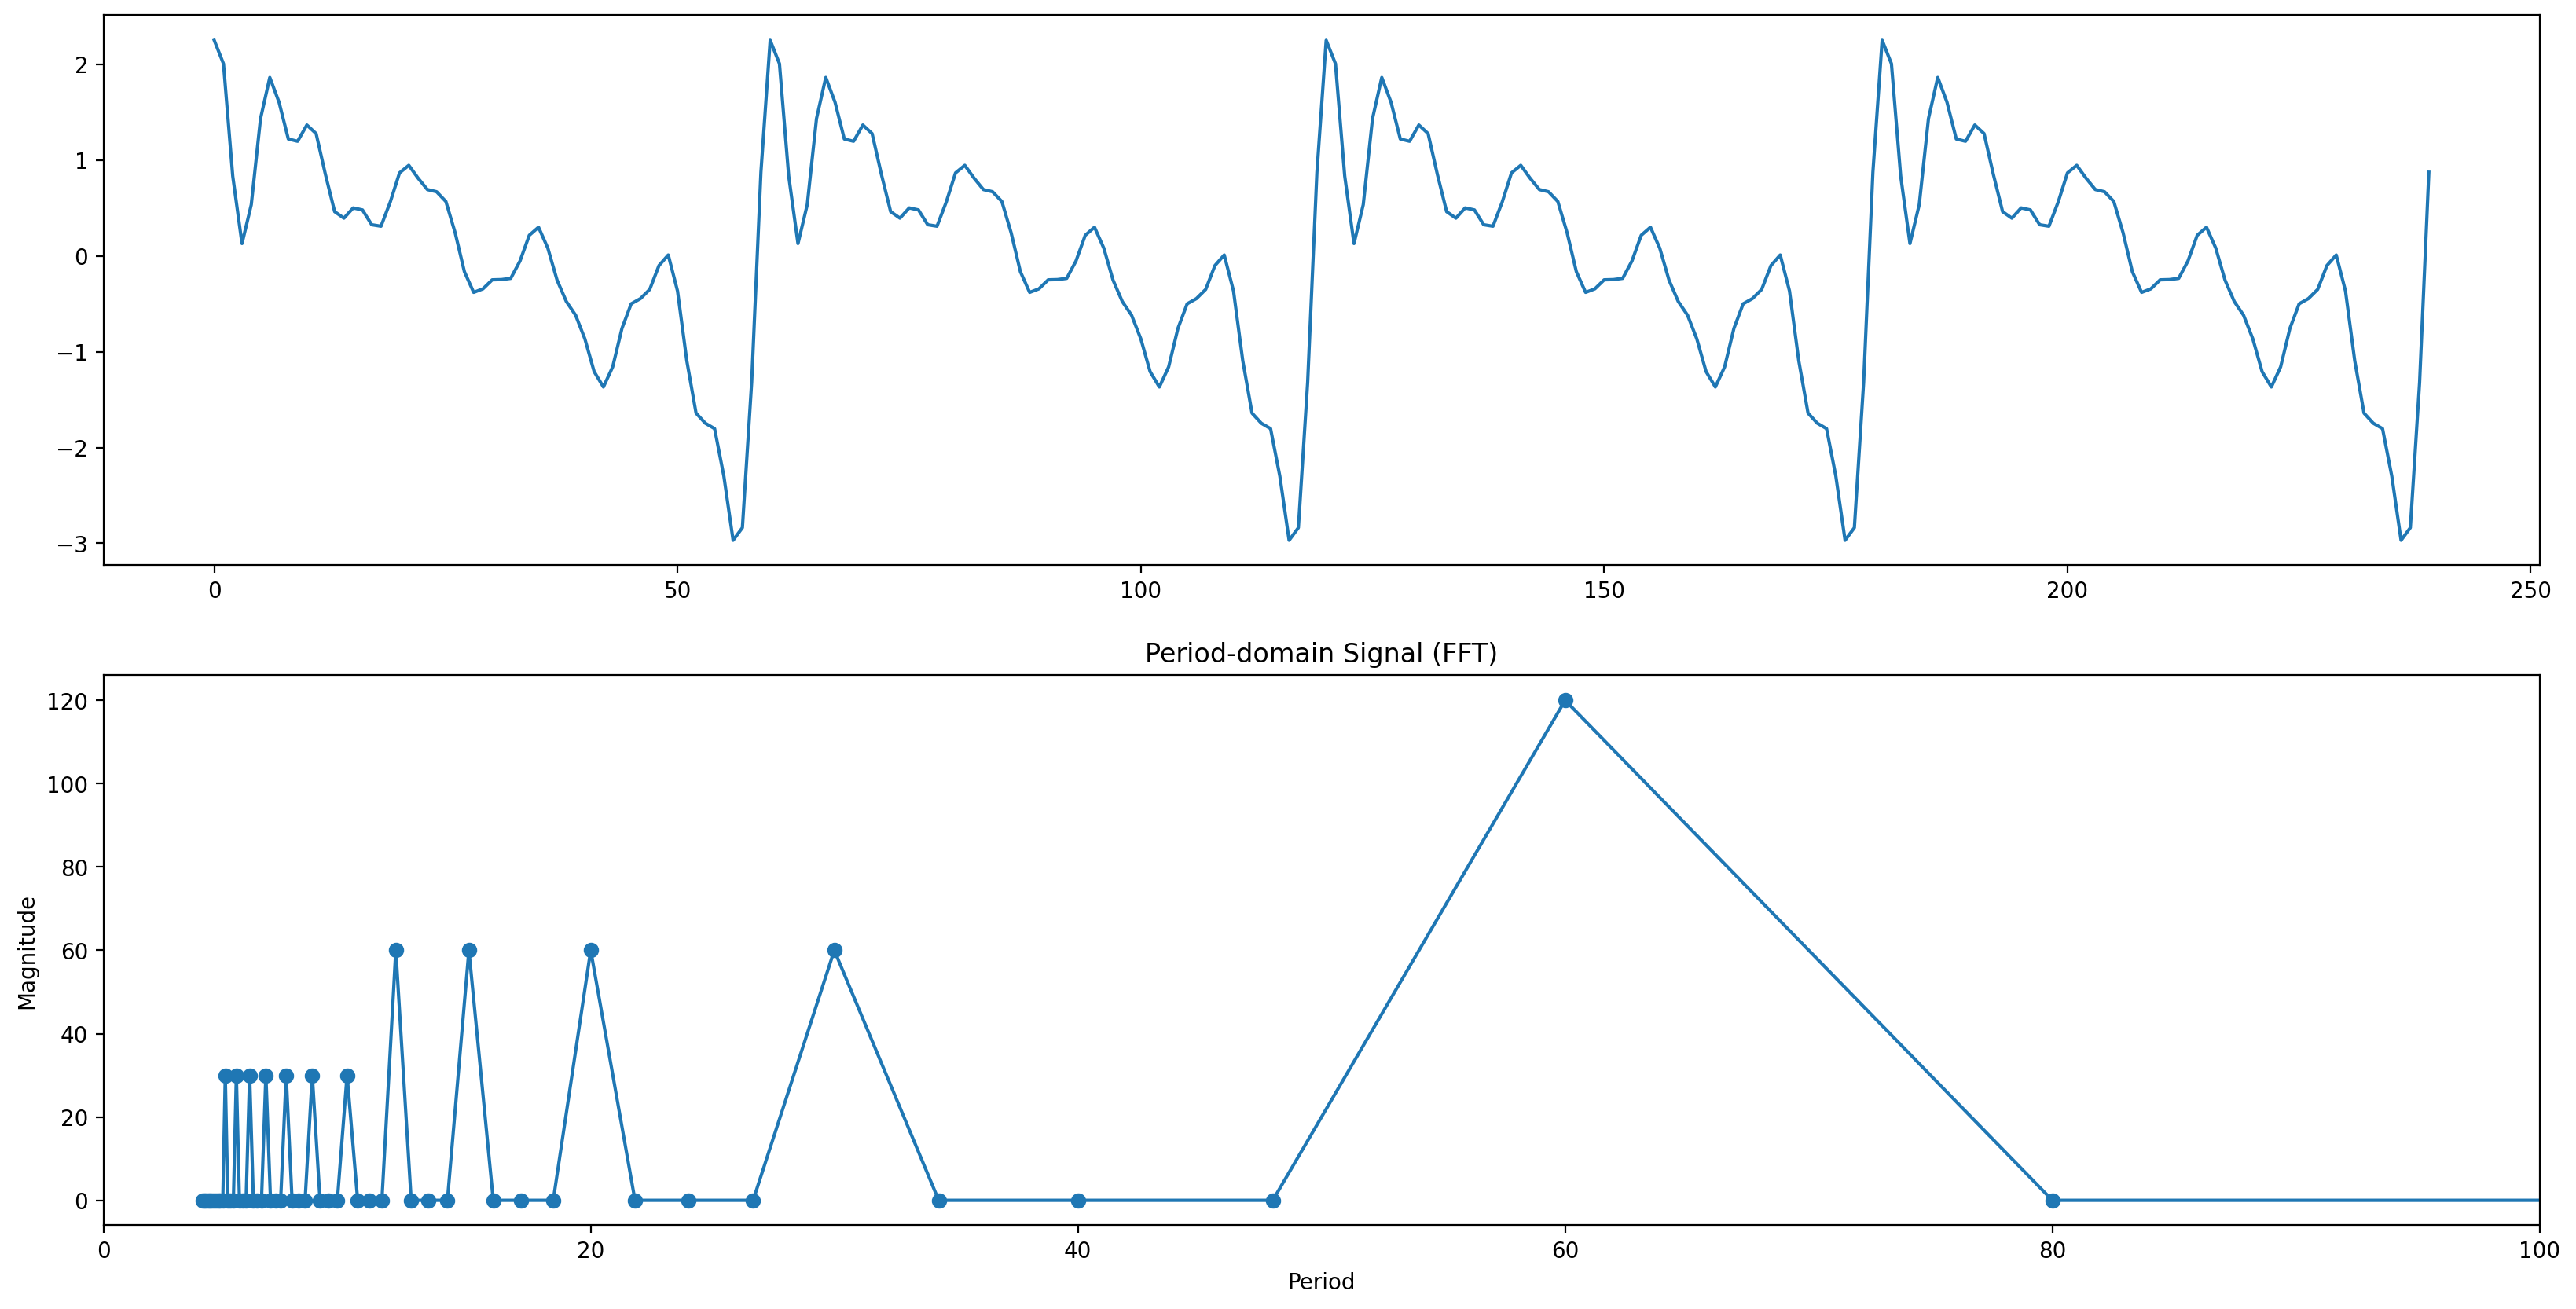

In [743]:
y = np.zeros(num_samples)
base_freq = 60

# n_harmonics = 12

# for i in range(n_harmonics):
#     y += sin_function(0.5, base_freq / (i + 1), 0 if i % 2 == 0 else np.pi / 2)

# # add linear looking trend
# y += sin_function(10, 240, 0)

# 1st harmonic
y = y + sin_function(1, base_freq, 0)

# 2nd harmonic
y += sin_function(0.5, base_freq / 2, 0)

# 3rd harmonic
y += sin_function(0.5, base_freq / 3, 0)

# 4th harmonic
y += sin_function(0.5, base_freq / 4, 0)

# 5th harmonic
y += sin_function(0.5, base_freq / 5, np.pi / 2)

# 6th harmonic
y += sin_function(0.25, base_freq / 6, np.pi / 2)

# 7th harmonic
y += sin_function(0.25, base_freq / 7, np.pi / 2)

# 8th harmonic
y += sin_function(0.25, base_freq / 8, np.pi / 2)

# 9th harmonic
y += sin_function(0.25, base_freq / 9, np.pi / 2)

# 10th harmonic
y += sin_function(0.25, base_freq / 10, np.pi / 2)

# 11th harmonic
y += sin_function(0.25, base_freq / 11, np.pi / 2)

# 12th harmonic
y += sin_function(0.25, base_freq / 12, np.pi / 2)


plt.figure(figsize=(20, 10))
# plt.plot(y[:120])

# plt.plot(np.abs(np.fft.rfft(y[:seq_len]))[:60])

fft_values = np.abs(np.fft.rfft(y[:240]))
frequencies = np.fft.rfftfreq(240, d=1)

fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(y[:240])
# ax[1].plot(np.abs(np.fft.rfft(y[:240]))[:60], "o-")

# ax[1].plot(frequencies[:60], fft_values[:60], "o-")
# ax[1].set_title("Frequency-domain Signal (FFT)")
# ax[1].set_xlabel("Frequency (Hz)")
# ax[1].set_ylabel("Magnitude")

frequencies = np.fft.rfftfreq(240, d=1)  # Assuming sample spacing of 1
periods = 1 / frequencies  # Compute periods

# Mask the zero frequency component to avoid division by zero
periods[0] = np.inf

ax[1].plot(periods[:60], fft_values[:60], "o-")
ax[1].set_xlim(0, 100)
ax[1].set_title("Period-domain Signal (FFT)")
ax[1].set_xlabel("Period")
ax[1].set_ylabel("Magnitude")
# ax[1].invert_xaxis()

In [744]:
args = Namespace(
    dominance_freq=int((240 / base_freq) * cut_off_harmonic),
    seq_len=240,
    pred_len=120,
    channels=1,
    individual=False,
    debug=True,
)

model = FITS(args)

print(model)

FITS(
  (frequency_upsampler): Linear(in_features=20, out_features=30, bias=True)
)


In [745]:
model_optim = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [746]:
def train(model, model_optim, n_channels, y):
    for epoch in range(1000):  # train 1000 epochs
        order = np.random.permutation(
            int(num_samples * 0.8)
        )  # shuffle the training sample
        train_loss = []
        for batch in range(25):  # split each epoch into 25 batches
            batch_start = order[
                batch * 80 : (batch + 1) * 80
            ]  # each batch has 80 samples
            batch = []

            for i in batch_start:
                batch.append(y[i : i + 240 + 120])

            batch_xy = np.array(batch).reshape(
                80, 360, n_channels
            )  # 80 batch_size, 360 time steps, n features

            batch_xy = torch.from_numpy(batch_xy).float()

            batch_x = batch_xy[:, :240, :]
            batch_y = batch_xy[:, 240:, :]

            model_optim.zero_grad()

            output = model(batch_x)

            # output=output[:,-120:,:]

            loss = criterion(output, batch_xy)

            train_loss.append(loss.item())

            loss.backward()

            model_optim.step()

        print(f"\repoch: {epoch} \t loss: {np.mean(train_loss):4f}", end="", flush=True)
    return model, np.mean(train_loss)

In [687]:
model, train_loss = train(model, model_optim, 1, y)

epoch: 0 	 loss: 2.029342

epoch: 999 	 loss: 0.343750

In [688]:
batch_xy = np.array([y[: 240 + 120]]).reshape(1, 360, 1)
batch_xy = torch.from_numpy(batch_xy).float()
with torch.no_grad():
    model.eval()
    output = model(batch_xy[:, :240, :])

Text(0, 0.5, 'Magnitude')

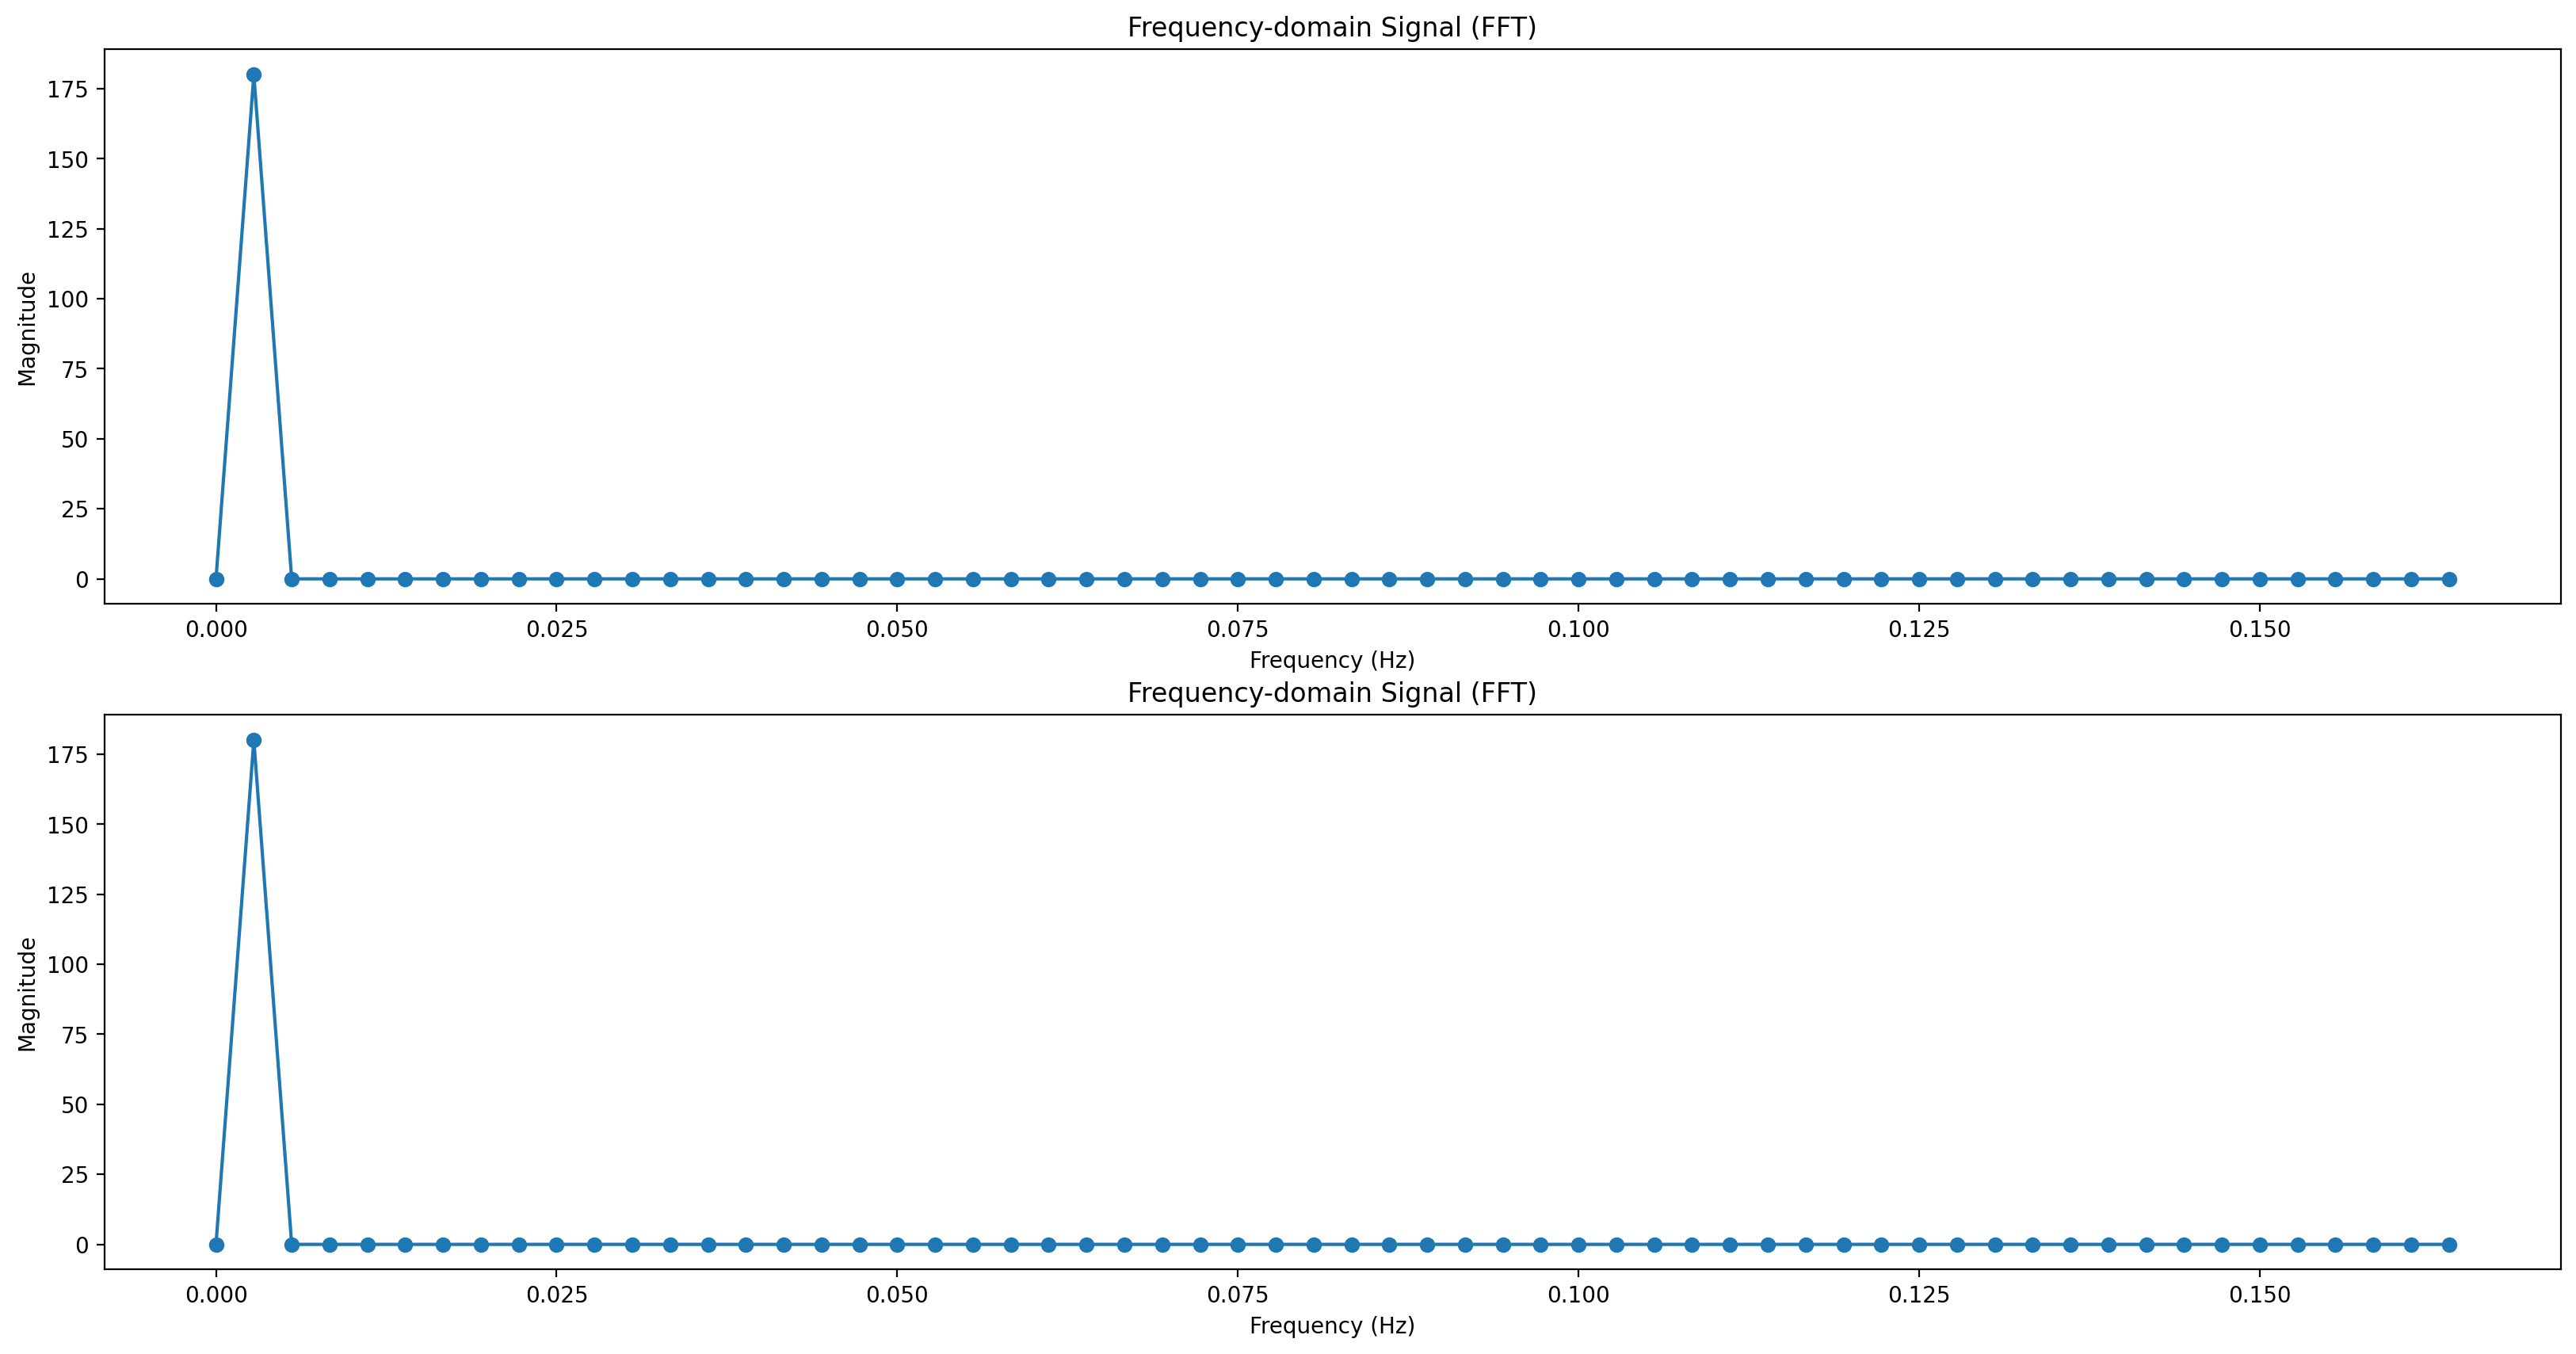

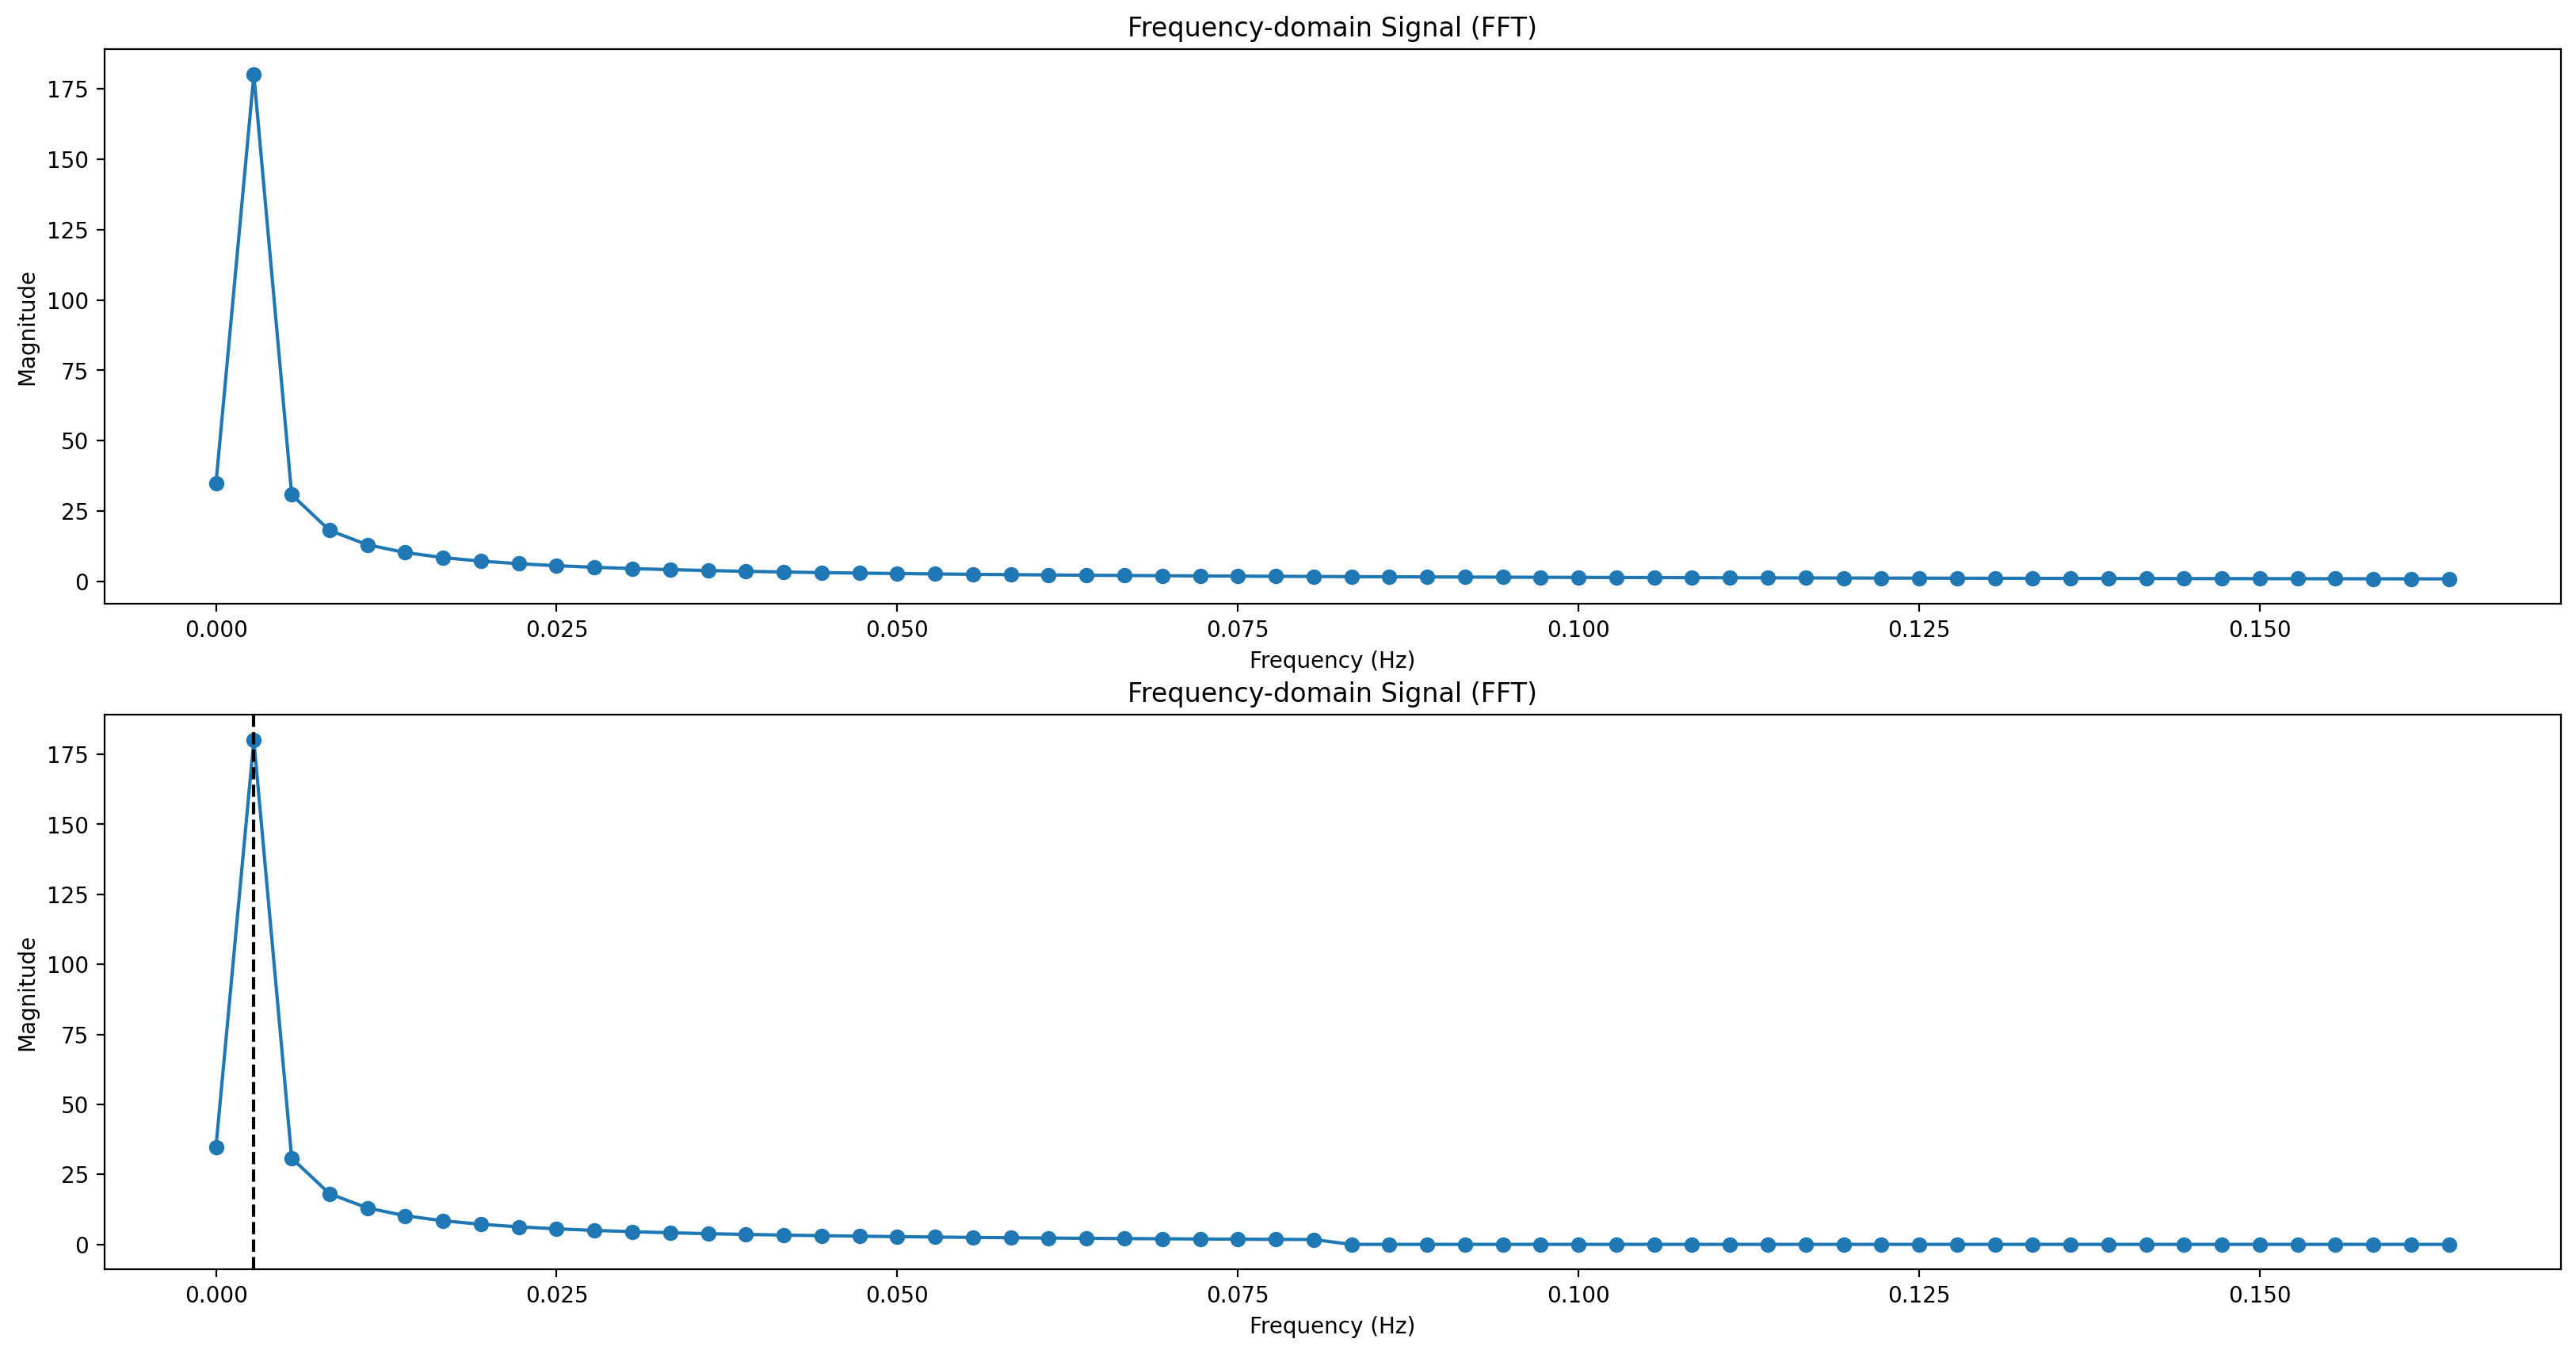

In [689]:
# lowest frequency FITS can capture
output = output.cpu().detach().numpy()
batch_xy = batch_xy.cpu().detach().numpy()

lowest_freq = 1 / (240 + 120)

# fft plots for the training result
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
fft_values = np.abs(np.fft.rfft(bxy1[0, :, 0]))
frequencies = np.fft.rfftfreq(360, d=1)
plt.plot(frequencies[:60], fft_values[:60], "o-")
plt.title("Frequency-domain Signal (FFT)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.subplot(2, 1, 2)
fft_values = np.abs(np.fft.rfft(o1[0, :, 0]))
frequencies = np.fft.rfftfreq(360, d=1)
plt.plot(frequencies[:60], fft_values[:60], "o-")
plt.title("Frequency-domain Signal (FFT)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")

# for the input
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
fft_values = np.abs(np.fft.rfft(bxy2[0, :, 0]))
frequencies = np.fft.rfftfreq(360, d=1)
plt.plot(frequencies[:60], fft_values[:60], "o-")
plt.title("Frequency-domain Signal (FFT)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.subplot(2, 1, 2)
fft_values = np.abs(np.fft.rfft(o2[0, :, 0]))
frequencies = np.fft.rfftfreq(360, d=1)
plt.plot(frequencies[:60], fft_values[:60], "o-")
plt.axvline(lowest_freq, linestyle="--", color="black")
plt.title("Frequency-domain Signal (FFT)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")

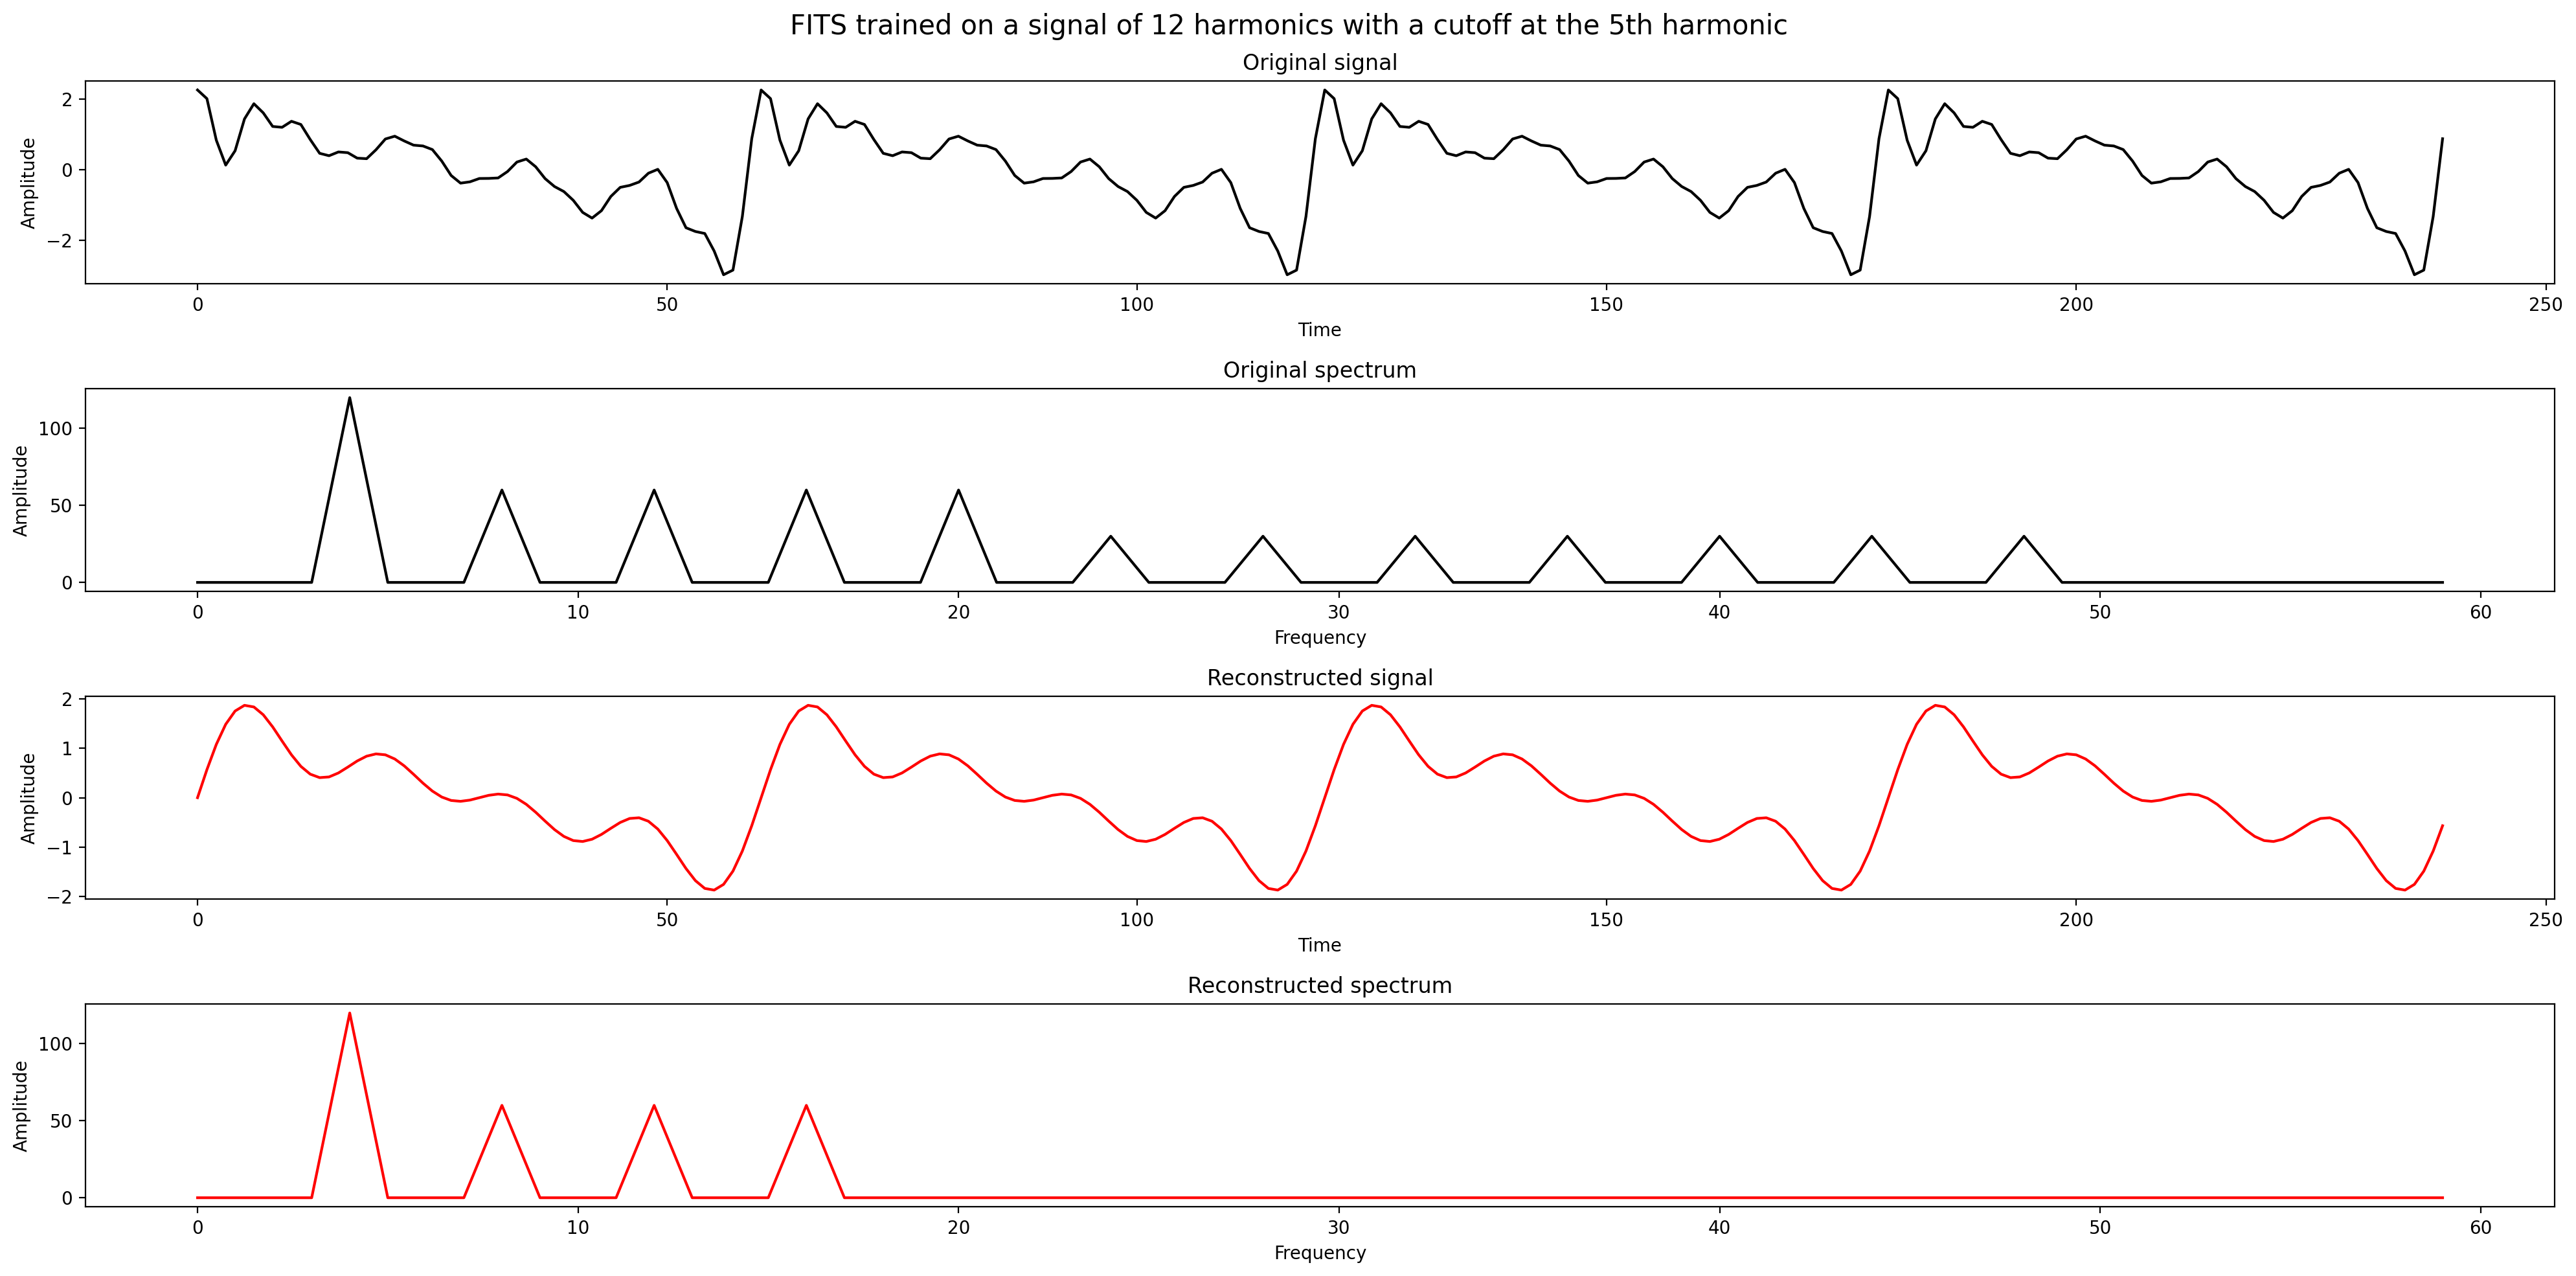

In [690]:
with torch.no_grad():
    output = model(torch.from_numpy(y[:240].reshape(1, 240, 1)).float())

fig, ax = plt.subplots(4, 1, figsize=(20, 10))
fig.suptitle(
    "FITS trained on a signal of 12 harmonics with a cutoff at the 5th harmonic",
    size=15,
)
ax[0].plot(y[:240], label="Original", color="black")
ax[0].set_title("Original signal")
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Time")
ax[1].plot(np.abs(np.fft.rfft(y[:240]))[:60], label="Original spectrum", color="black")
ax[1].set_title("Original spectrum")
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("Frequency")
ax[2].plot(output[0, :240, 0], label="Reconstructed", color="red")
ax[2].set_title("Reconstructed signal")
ax[2].set_ylabel("Amplitude")
ax[2].set_xlabel("Time")
ax[3].plot(
    np.abs(np.fft.rfft(output[0, :240, 0]))[:60],
    label="Reconstructed spectrum",
    color="red",
)
ax[3].set_title("Reconstructed spectrum")
ax[3].set_ylabel("Amplitude")
ax[3].set_xlabel("Frequency")
# for a in ax:
#     a.legend()
# plt.title("FITS trained on a signal of 12 harmonics with a cutoff at the 5th harmonic")
plt.tight_layout()
plt.show()

In [692]:
with torch.no_grad():
    model.eval()
    test_loss = []
    batch = []

    for i in range(int(num_samples * 0.8), num_samples - 360):
        batch.append(y[i : i + 240 + 120])
    batch_xy = np.array(batch).reshape(
        -1, 360, 1
    )  # 80 batch_size, 360 time steps, 1 feature

    batch_xy = torch.from_numpy(batch_xy).float()

    batch_x = batch_xy[:, :240, :]
    batch_y = batch_xy[:, 240:, :]

    model_optim.zero_grad()

    output = model(batch_x)

    # output=output[:,-120:,:]

    loss = criterion(
        output, batch_xy
    )  # supervise on xy (only supervise on y also achieve the same result)

    test_loss.append(loss.item())

    print("epoch: test loss: ", np.mean(test_loss))

epoch: test loss:  0.34375


In [693]:
output = output.cpu().detach().numpy()
batch_xy = batch_xy.cpu().detach().numpy()

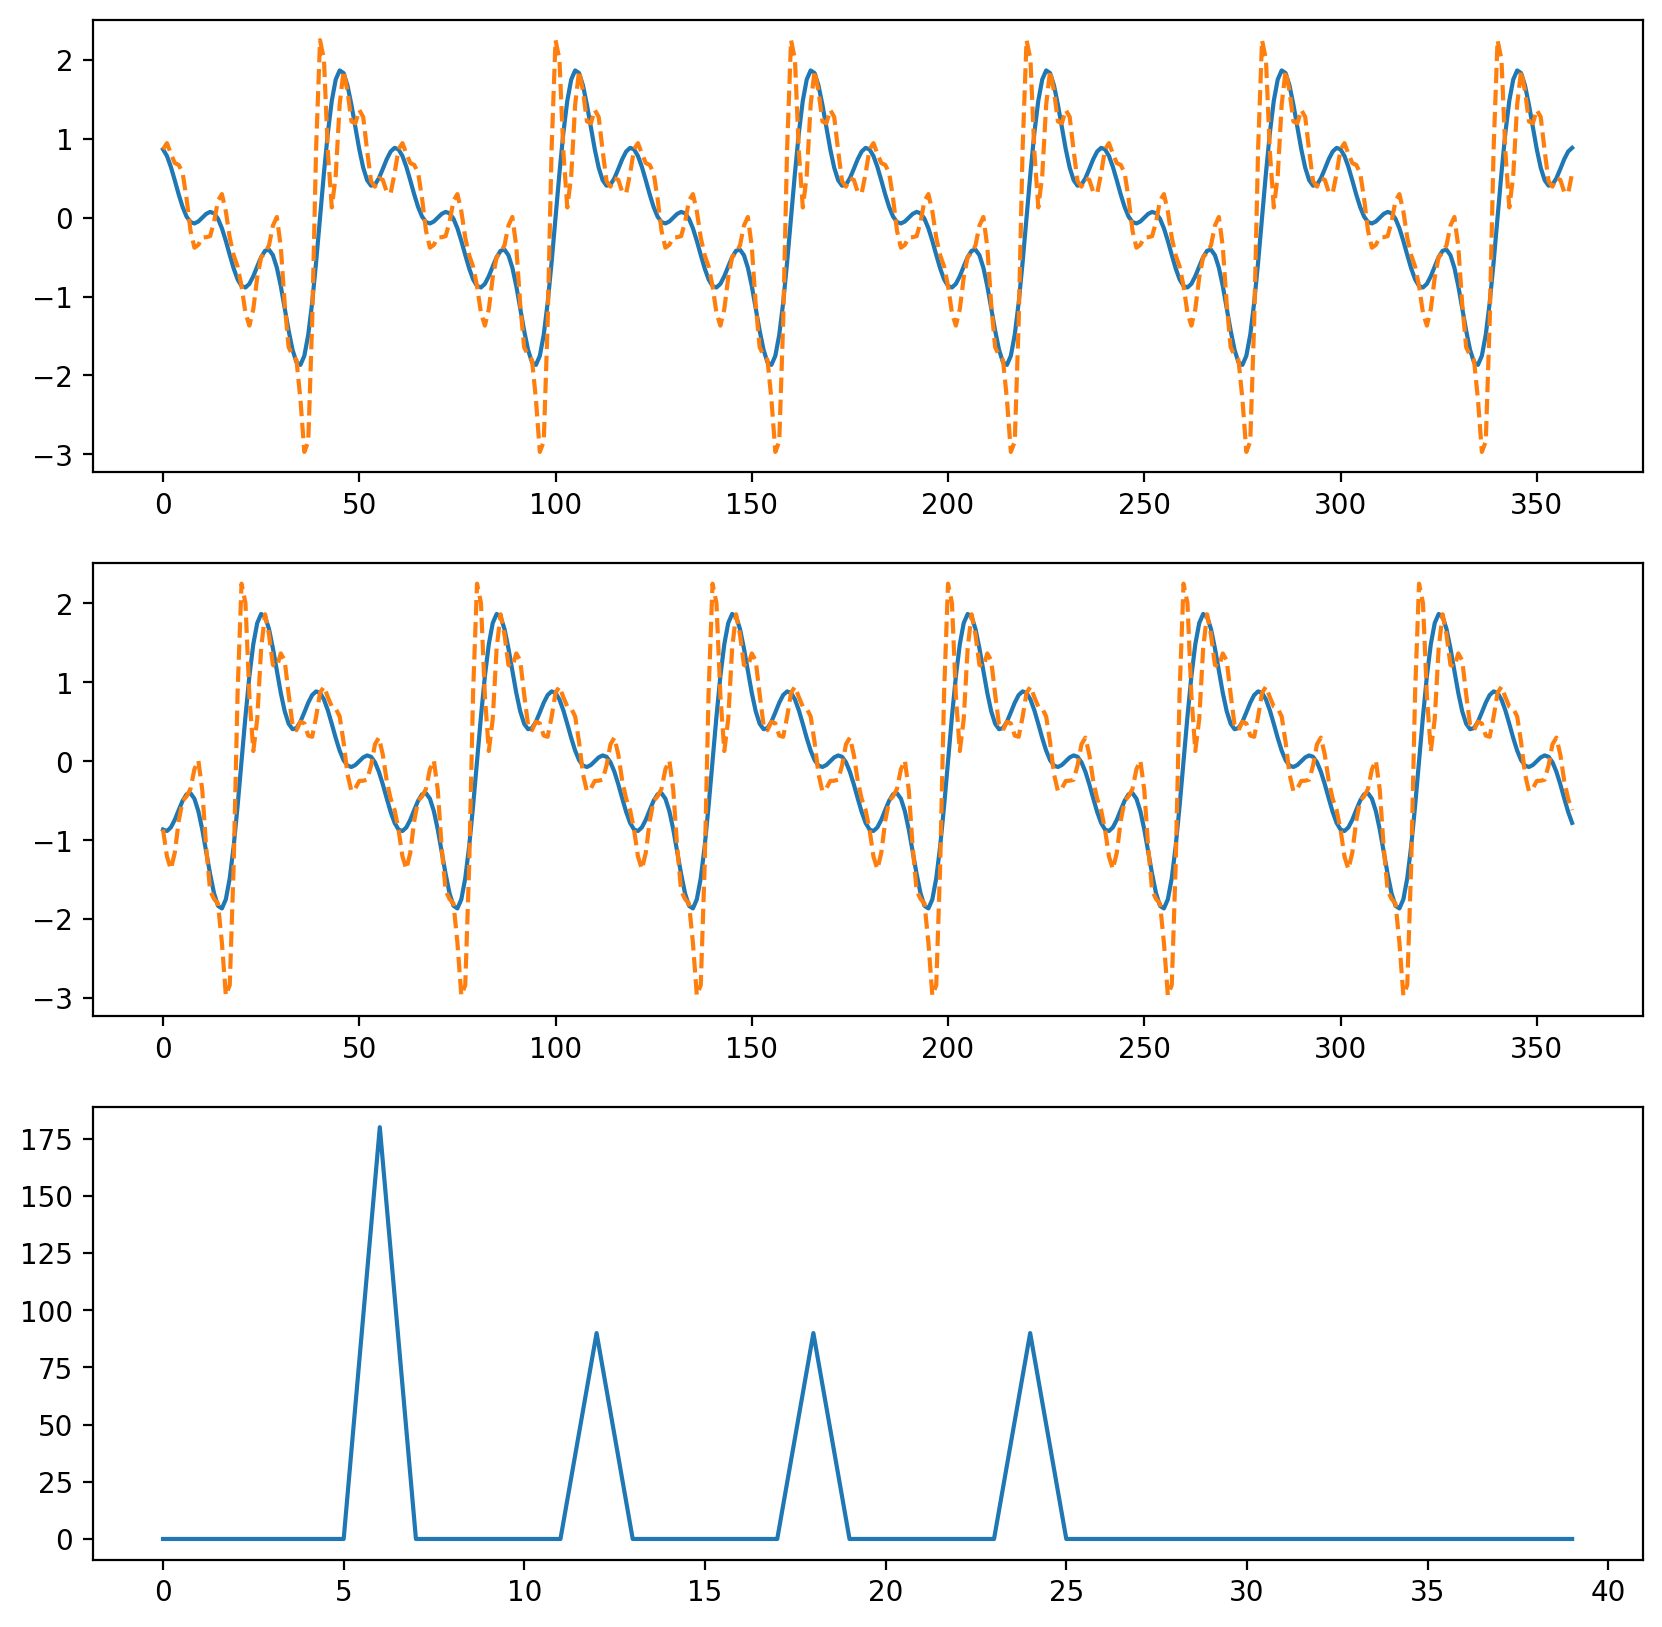

In [696]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(output[0, :, 0])  # prediction
plt.plot(batch_xy[0, :, 0], "--")  # ground truth
plt.subplot(3, 1, 2)
plt.plot(output[200, :, 0])
plt.plot(batch_xy[200, :, 0], "--")
plt.subplot(3, 1, 3)
plt.plot(np.abs(np.fft.rfft(output[0, :, 0])[:40]))

# Frequency response

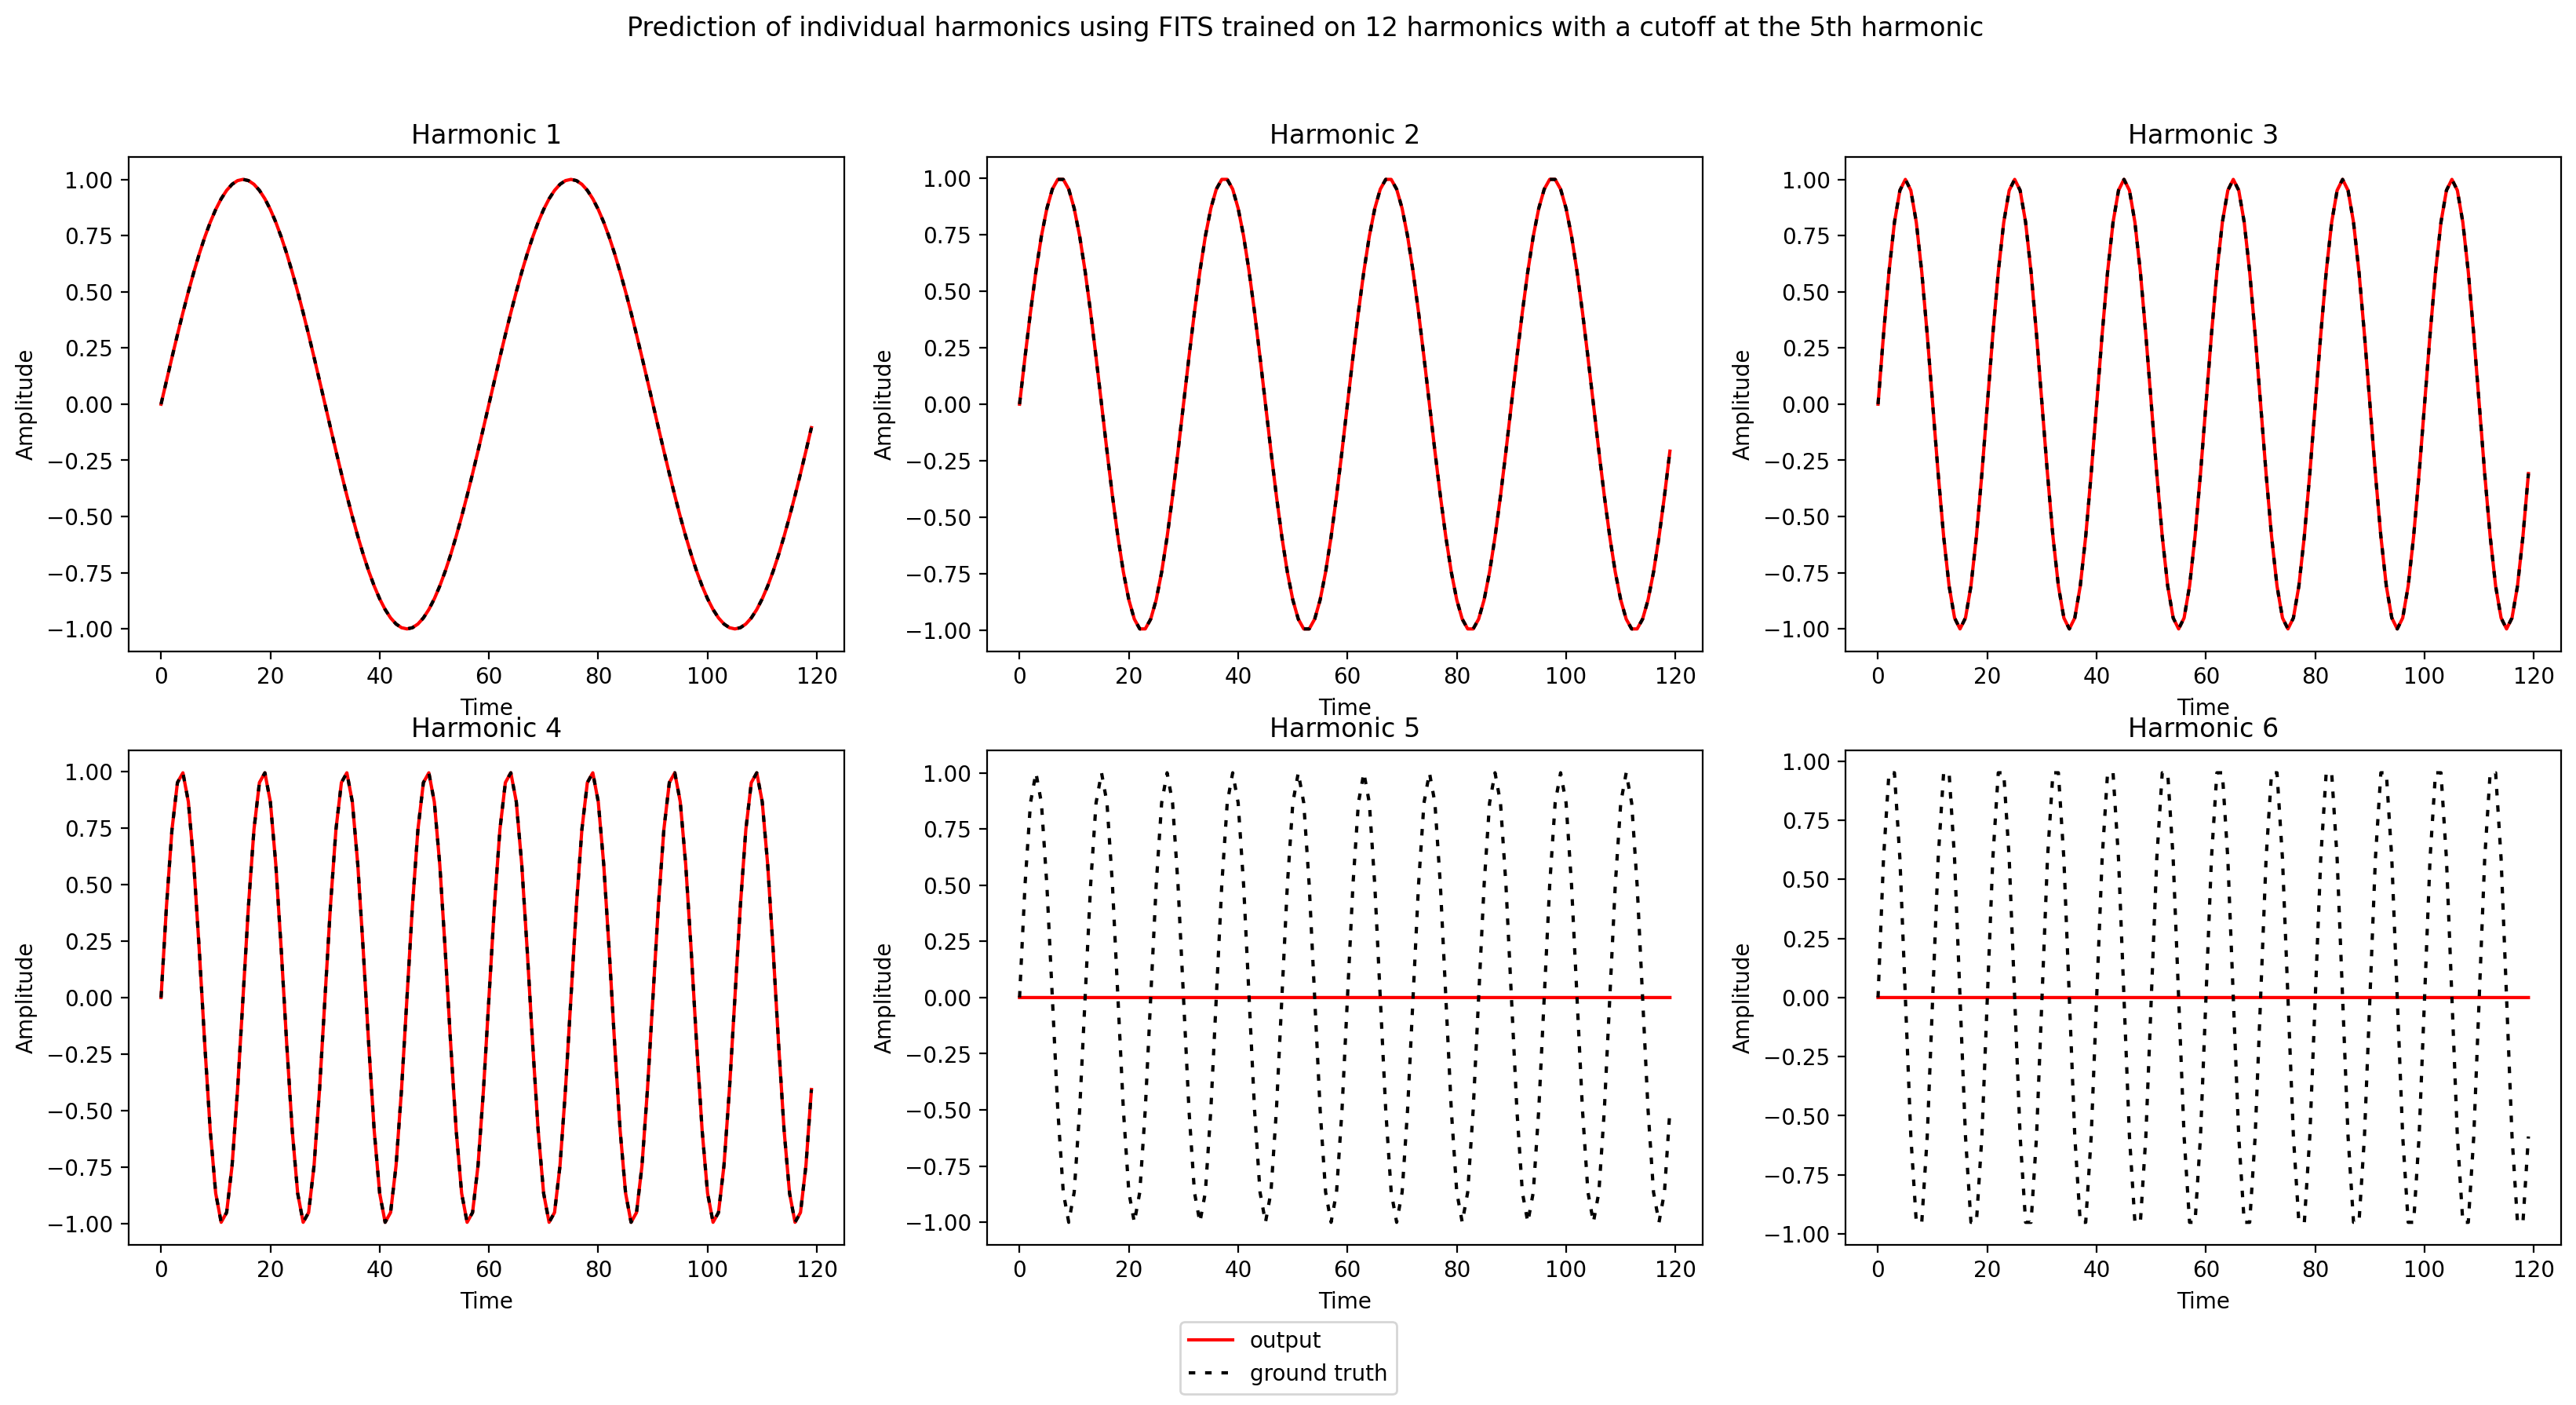

In [618]:
harmonic_bases = [1, 2, 3, 4, 5, 6]
fig, ax = plt.subplots(2, 3, figsize=(20, 9))

for harmonic_base in harmonic_bases:
    y1 = sin_function(1, base_freq / harmonic_base, 0)[:360]
    y1 = y1.reshape(1, 360, 1)
    y1 = torch.tensor(y1, dtype=torch.float32)
    with torch.no_grad():
        model.eval()
        batch_x1 = y1[:, :240, :]
        output = model(batch_x1)
        output = output.cpu().numpy()

        y1 = y1[:, :120, :]
        output = output[:, :120, :]

        ax[(harmonic_base - 1) // 3, (harmonic_base - 1) % 3].plot(
            output[0, :, 0], label="output", color="red"
        )
        ax[(harmonic_base - 1) // 3, (harmonic_base - 1) % 3].plot(
            y1[0, :, 0].cpu().numpy(), "--", color="black", dashes=(2, 3)
        )
        ax[(harmonic_base - 1) // 3, (harmonic_base - 1) % 3].set_title(
            f"Harmonic {harmonic_base}"
        )
        ax[(harmonic_base - 1) // 3, (harmonic_base - 1) % 3].set_ylabel("Amplitude")
        ax[(harmonic_base - 1) // 3, (harmonic_base - 1) % 3].set_xlabel("Time")

fig.suptitle(
    "Prediction of individual harmonics using FITS trained on 12 harmonics with a cutoff at the 5th harmonic"
)
fig.legend(["output", "ground truth"], loc="lower center")
plt.show()

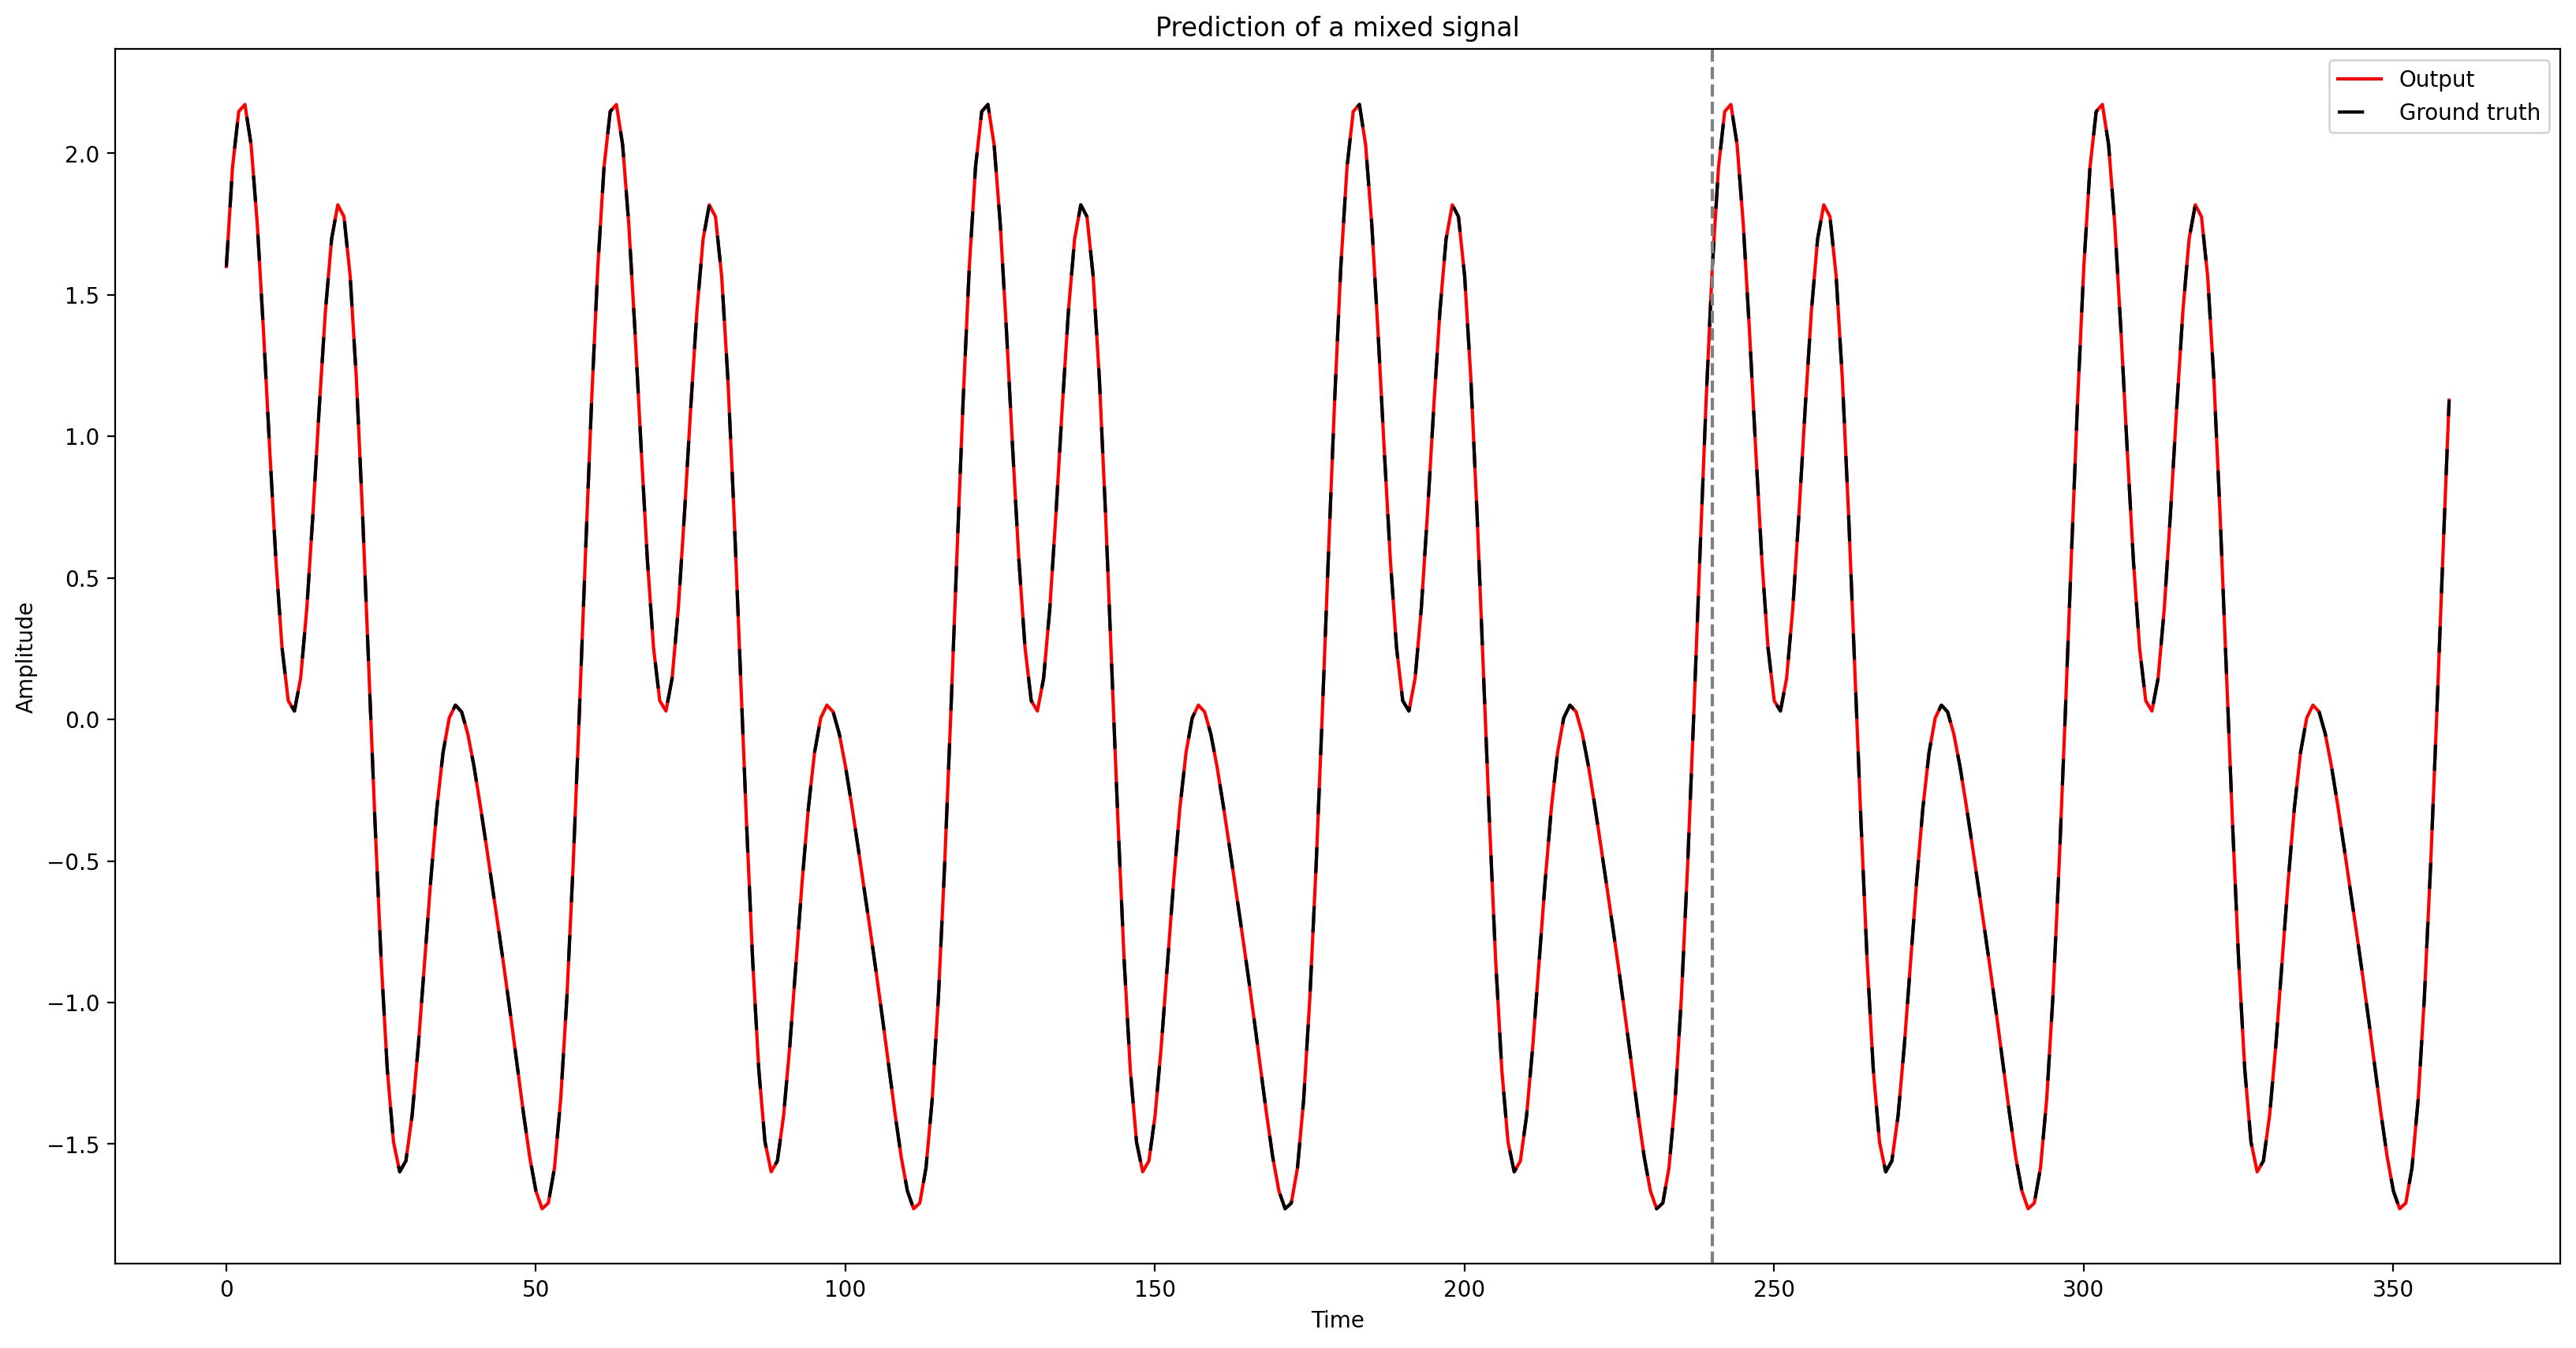

In [697]:
y_mix = (
    sin_function(1, 60, 0)[:360]
    + sin_function(0.5, 60, np.pi / 2)[:360]
    + sin_function(0.5, 30, 0)[:360]
    + sin_function(0.5, 20, np.pi / 2)[:360]
    + sin_function(0.5, 20, np.pi / 2)[:360]
    + sin_function(0.5, 15, 0)[:360]
    + sin_function(0.1, 15, np.pi / 2)[:360]
    # + sin_function(2, 24, np.pi / 2)[:360]
    # + sin_function(3, 60, np.pi / 2)[:360]
    # + sin_function(4, 30, np.pi / 2)[:360]
    # + sin_function(2, 24, np.pi / 2)[:360]
    # + sin_function(-1, 120, np.pi / 1)[:360]
    # + sin_function(-2, 60, np.pi / 1)[:360]
    # + sin_function(-3, 60, np.pi / 2)[:360]
    # + sin_function(1, 30, np.pi / 1)[:360]
)
y_mix = y_mix.reshape(1, 360, 1)
y_mix = torch.tensor(y_mix, dtype=torch.float32)

with torch.no_grad():
    model.eval()
    batch_x_mix = y_mix[:, :240, :]
    output = model(batch_x_mix)
    output = output.cpu().numpy()
    plt.figure(figsize=(20, 10))
    plt.plot(output[0, :, 0], label="Output", color="red")
    plt.plot(
        y_mix[0, :, 0].cpu().numpy(),
        "--",
        label="Ground truth",
        color="black",
        dashes=(8, 10),
    )
    plt.axvline(x=240, color="grey", linestyle="--")
    plt.title("Prediction of a mixed signal")
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.legend()

# Higher period than output length

In [620]:
y = np.zeros(num_samples)

y += sin_function(1, 360 * 1, 0)

model, train_loss = train(model, model_optim, 1, y)

batch_xy = np.array([y[: 240 + 120]]).reshape(1, 360, 1)
batch_xy = torch.from_numpy(batch_xy).float()
with torch.no_grad():
    model.eval()
    output = model(batch_xy[:, :240, :])


output = output.cpu().detach().numpy()
batch_xy = batch_xy.cpu().detach().numpy()
o1 = output
bxy1 = batch_xy
train_loss_1 = np.mean(train_loss)

epoch: 999 	 loss: 0.000000

In [621]:
y = np.zeros(num_samples)
base_freq = 60

# # add linear looking trend
y += sin_function(1, 360 * 1.2, 0)

model, train_loss = train(model, model_optim, 1, y)

batch_xy = np.array([y[: 240 + 120]]).reshape(1, 360, 1)
batch_xy = torch.from_numpy(batch_xy).float()
with torch.no_grad():
    model.eval()
    output = model(batch_xy[:, :240, :])


output = output.cpu().detach().numpy()
batch_xy = batch_xy.cpu().detach().numpy()
o2 = output
bxy2 = batch_xy
train_loss_2 = np.mean(train_loss)

epoch: 12 	 loss: 0.015684

epoch: 999 	 loss: 0.000864

In [622]:
y = np.zeros(num_samples)
base_freq = 60

y += sin_function(1, 360 * 2.0, 0)

model, train_loss_3 = train(model, model_optim, 1, y)

batch_xy = np.array([y[120 : 120 + 240 + 120]]).reshape(1, 360, 1)
batch_xy = torch.from_numpy(batch_xy).float()
with torch.no_grad():
    model.eval()
    output = model(batch_xy[:, :240, :])


output = output.cpu().detach().numpy()
batch_xy = batch_xy.cpu().detach().numpy()
o3 = output
bxy3 = batch_xy

epoch: 10 	 loss: 0.030822

epoch: 999 	 loss: 0.003346

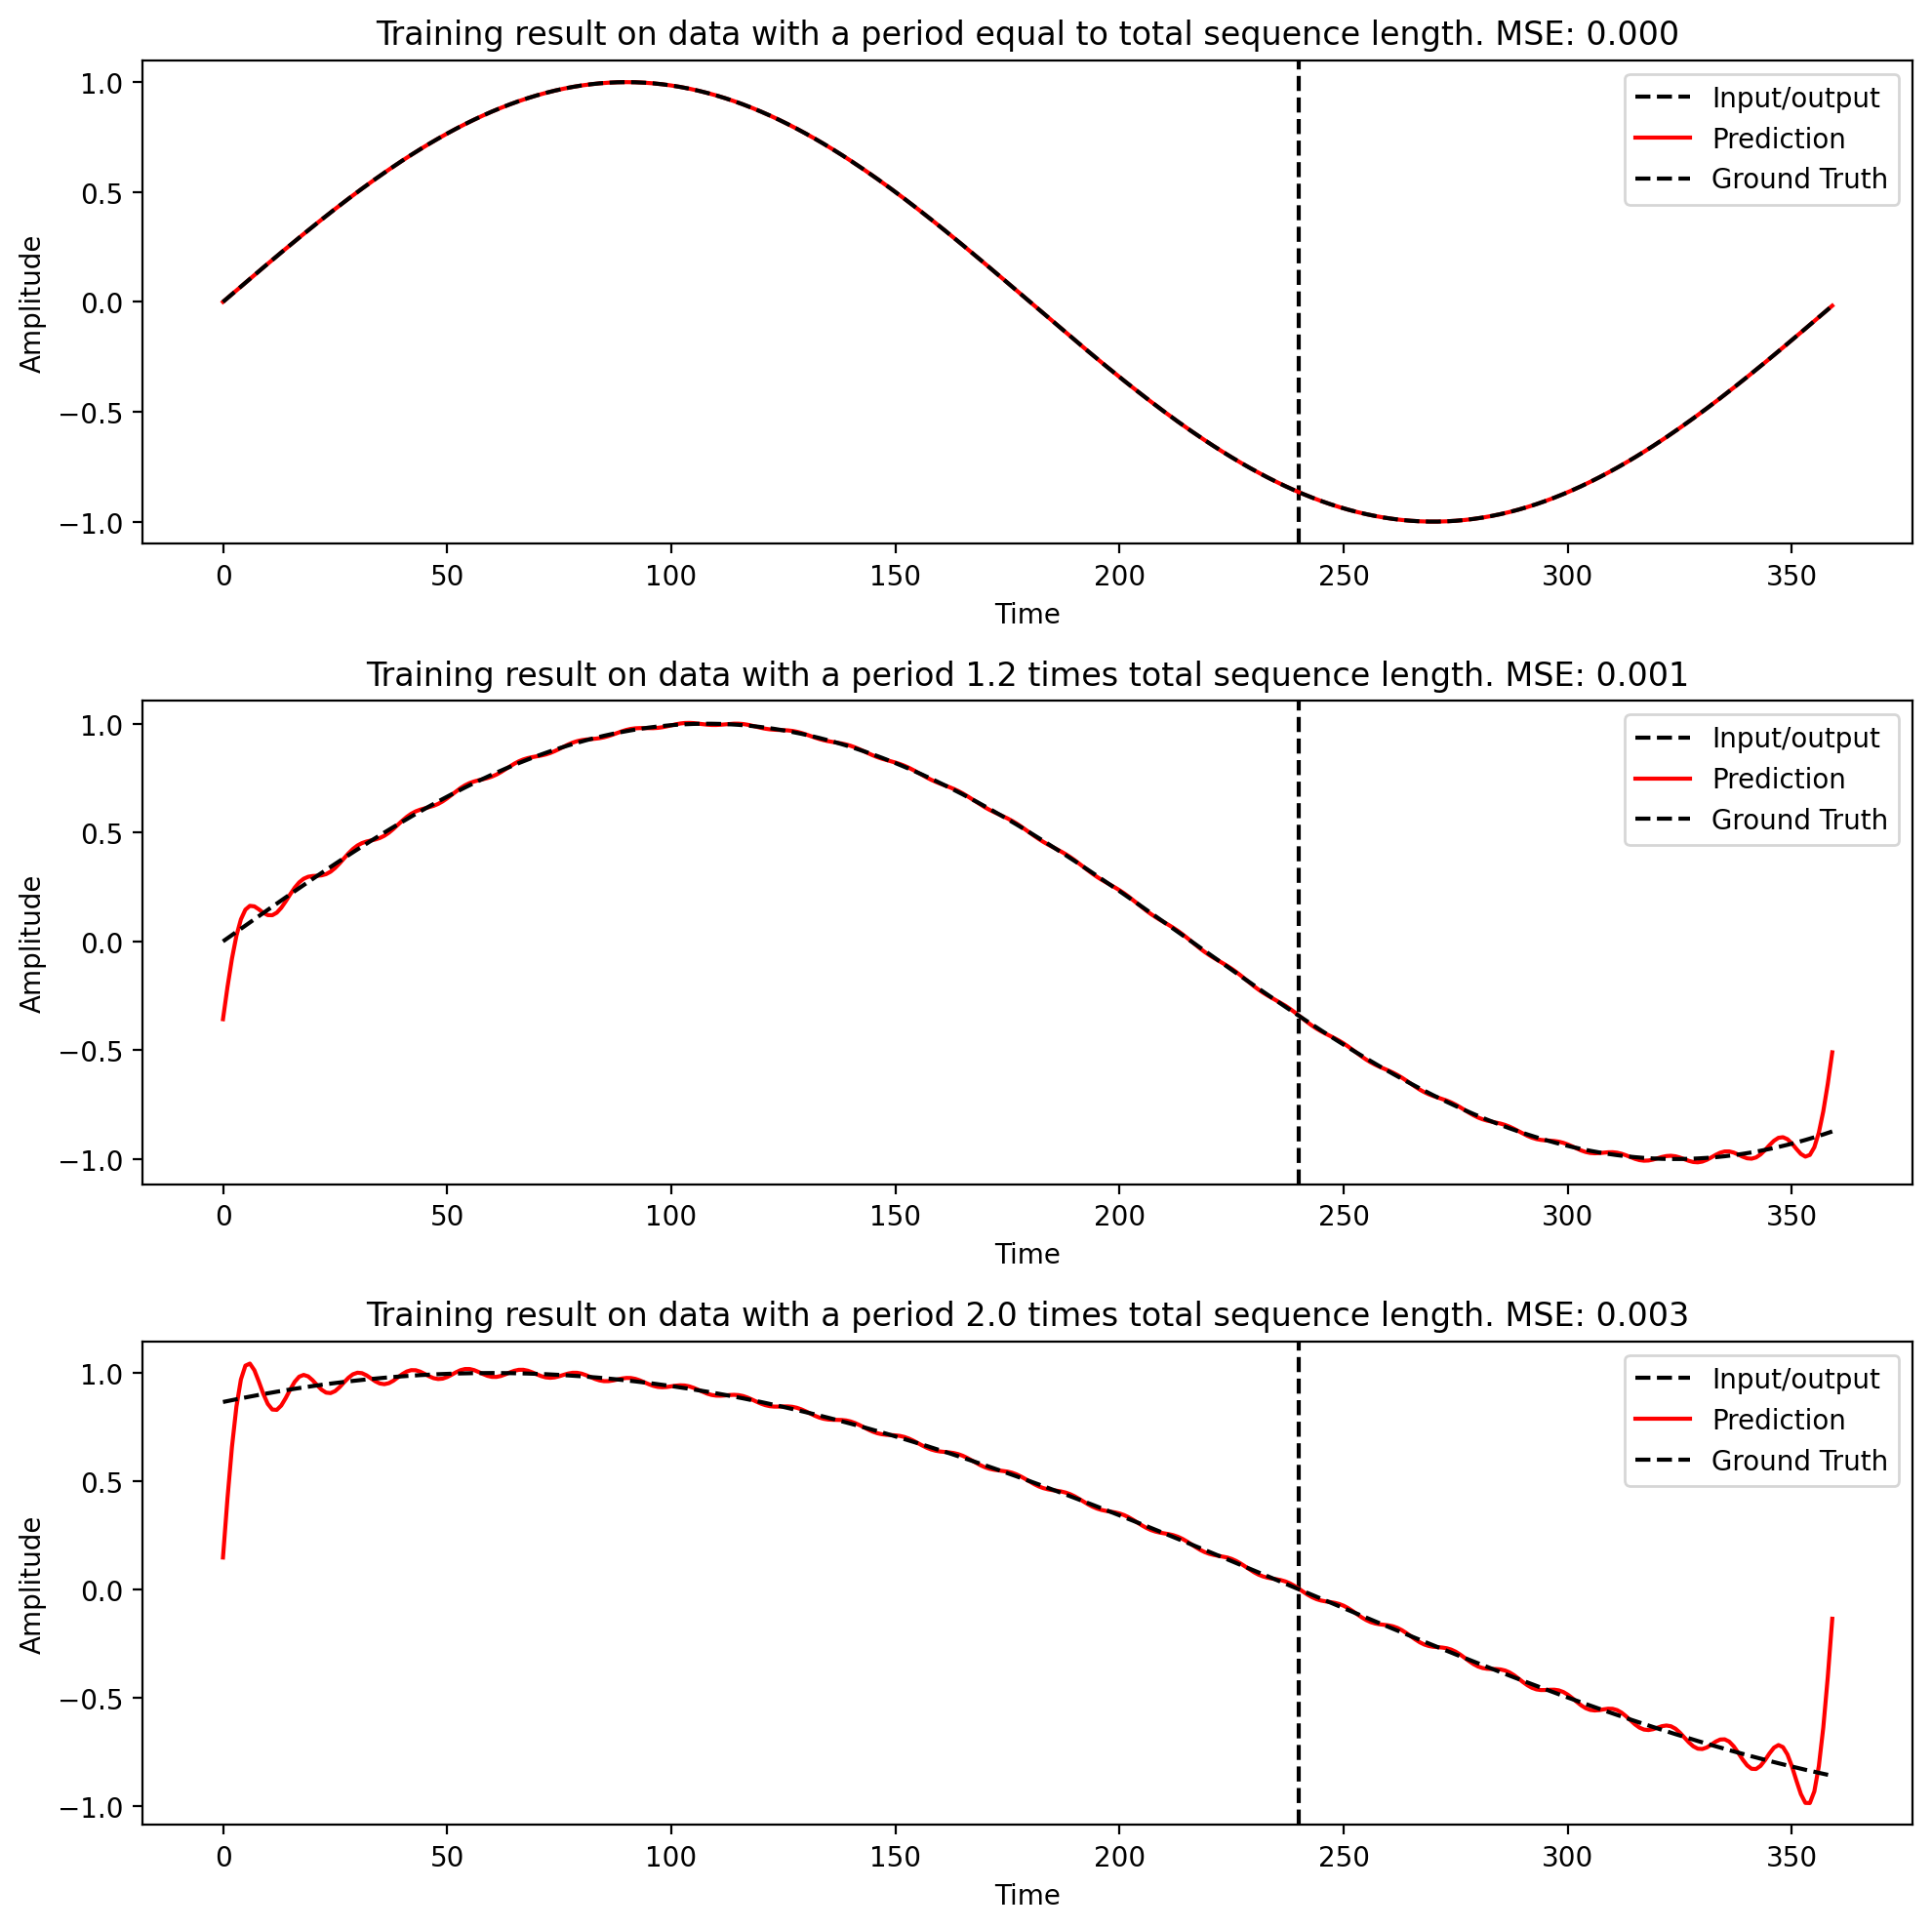

In [623]:
# Visualize the training result
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.axvline(240, linestyle="--", color="black")  # separate training and testing
plt.plot(o1[0, :, 0], color="r")  # prediction
plt.plot(bxy1[0, :, 0], "--", color="black")  # ground truth
plt.title(
    f"Training result on data with a period equal to total sequence length. MSE: {train_loss_1:.3f}"
)
plt.legend(["Input/output", "Prediction", "Ground Truth"])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.subplot(3, 1, 2)
plt.axvline(240, linestyle="--", color="black")  # separate training and testing
plt.plot(o2[0, :, 0], color="r")  # prediction
plt.plot(bxy2[0, :, 0], "--", color="black")  # ground truth
plt.title(
    f"Training result on data with a period 1.2 times total sequence length. MSE: {train_loss_2:.3f}"
)
plt.legend(["Input/output", "Prediction", "Ground Truth"])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.subplot(3, 1, 3)
plt.axvline(240, linestyle="--", color="black")  # separate training and testing
plt.plot(o3[0, :, 0], color="r")  # prediction
plt.plot(bxy3[0, :, 0], "--", color="black")  # ground truth
plt.title(
    f"Training result on data with a period 2.0 times total sequence length. MSE: {train_loss_3:.3f}"
)
plt.legend(["Input/output", "Prediction", "Ground Truth"])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.tight_layout()
plt.show()

# Heaviside

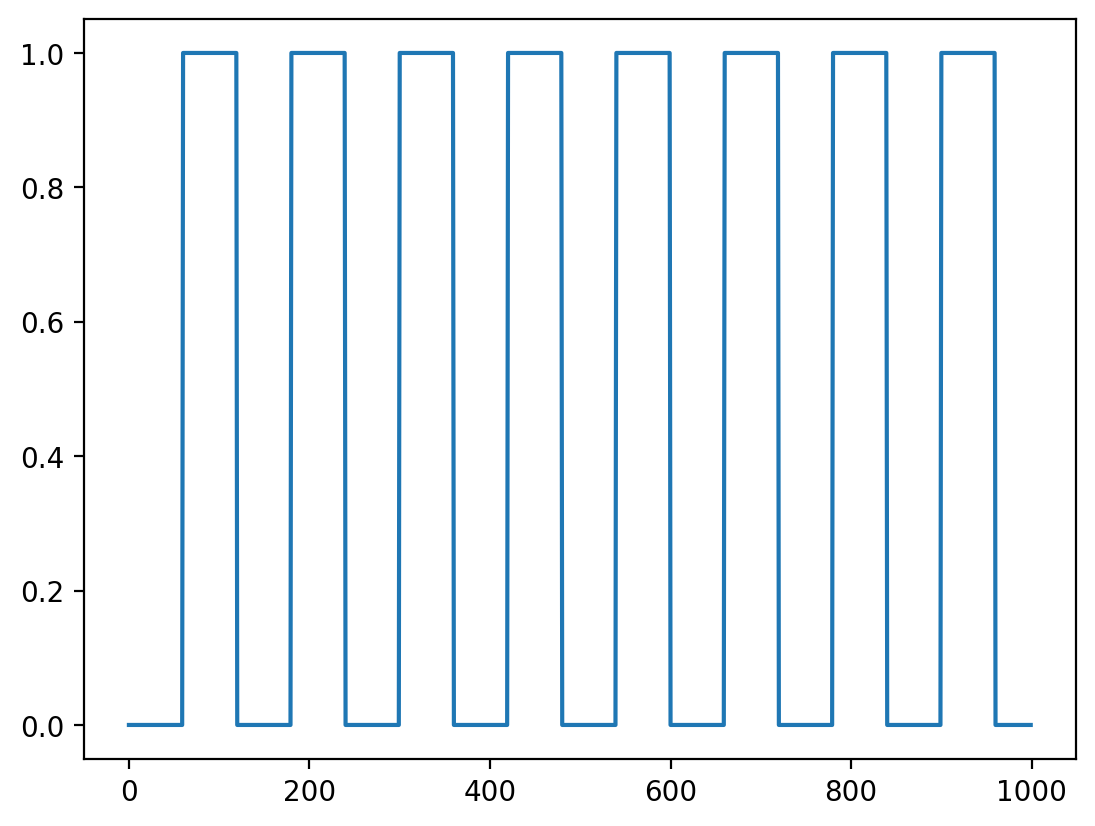

In [757]:
def periodic_heaviside(x, T):
    return np.heaviside((x % T) - T / 2, 1)


y = periodic_heaviside(np.arange(num_samples), 120)
plt.plot(y[:1000])

In [759]:
args = Namespace(
    dominance_freq=40,
    seq_len=240,
    pred_len=120,
    channels=1,
    individual=False,
    debug=True,
)

model = FITS(args)

model_optim = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

print(model)

FITS(
  (frequency_upsampler): Linear(in_features=40, out_features=60, bias=True)
)


In [760]:
model, train_loss = train(model, model_optim, 1, y)

epoch: 999 	 loss: 0.004590

In [761]:
batch_xy = np.array([y[: 240 + 120]]).reshape(1, 360, 1)
batch_xy = torch.from_numpy(batch_xy).float()
with torch.no_grad():
    model.eval()
    output = model(batch_xy[:, :240, :])

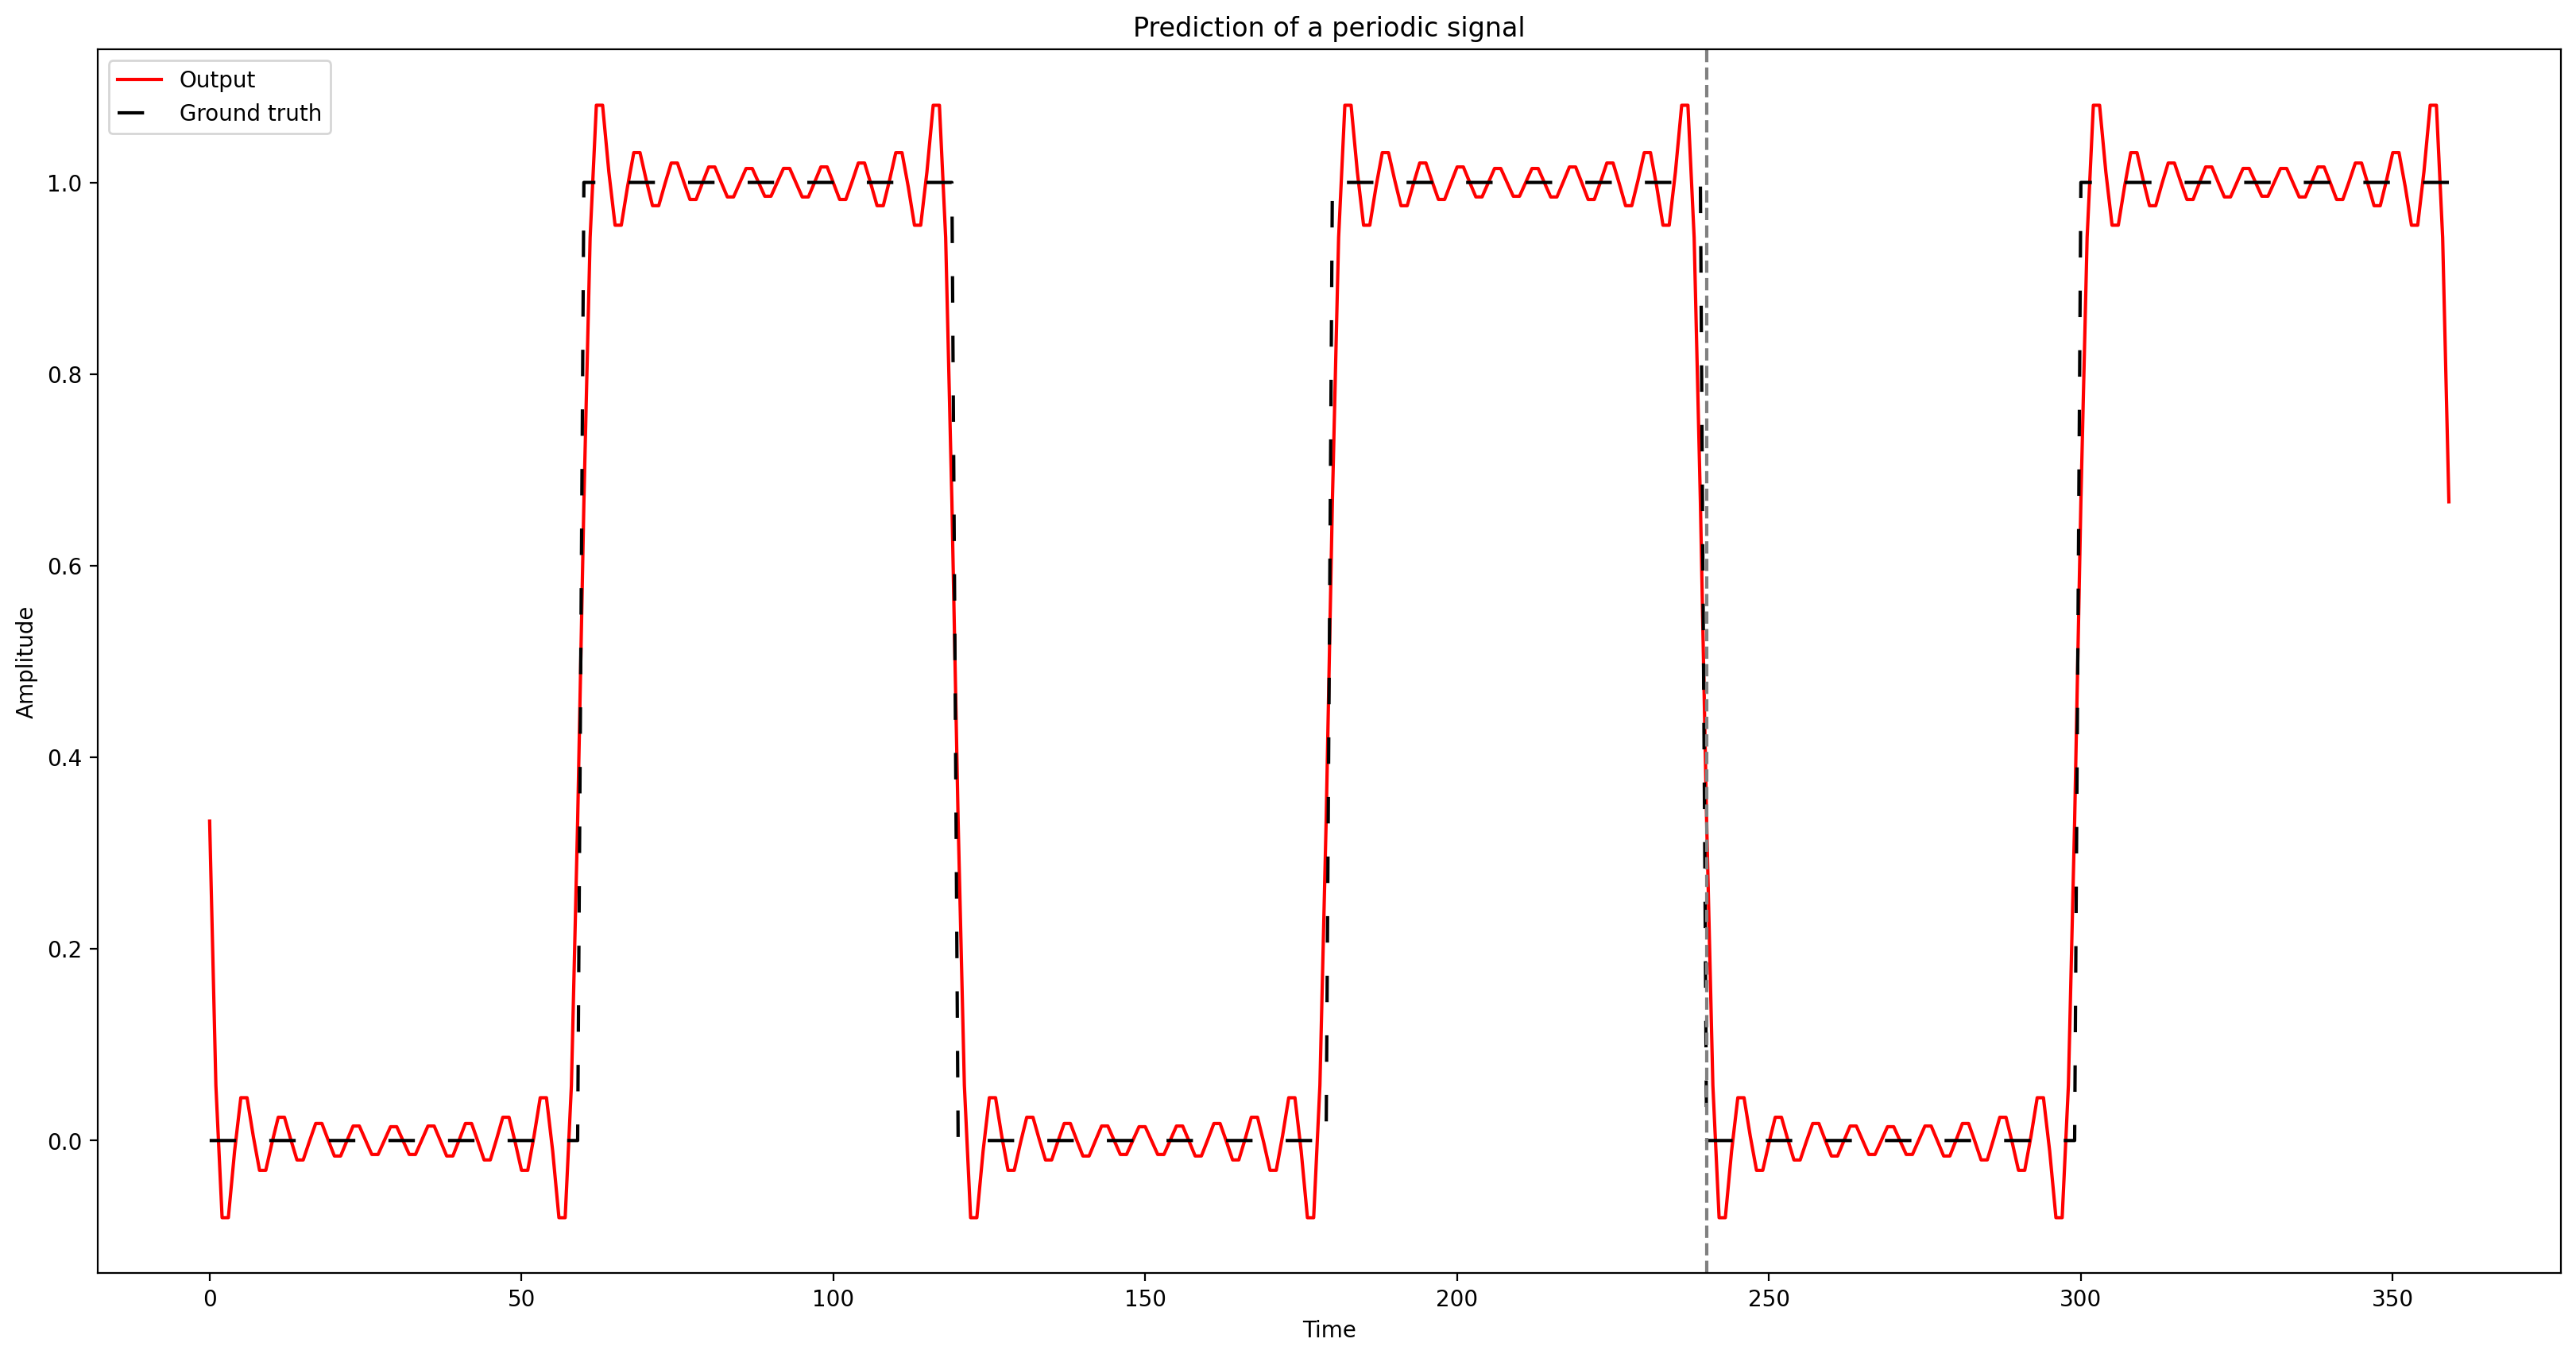

In [762]:
output = output.cpu().detach().numpy()

plt.figure(figsize=(20, 10))
plt.plot(output[0, :, 0], label="Output", color="red")
plt.plot(y[:360], "--", label="Ground truth", color="black", dashes=(8, 10))
plt.axvline(x=240, color="grey", linestyle="--")
plt.title("Prediction of a periodic signal")
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.legend()

# Multichannel

- If the base period of the signal is greater than half the total output length MSE can never be 0


## Channels summed up

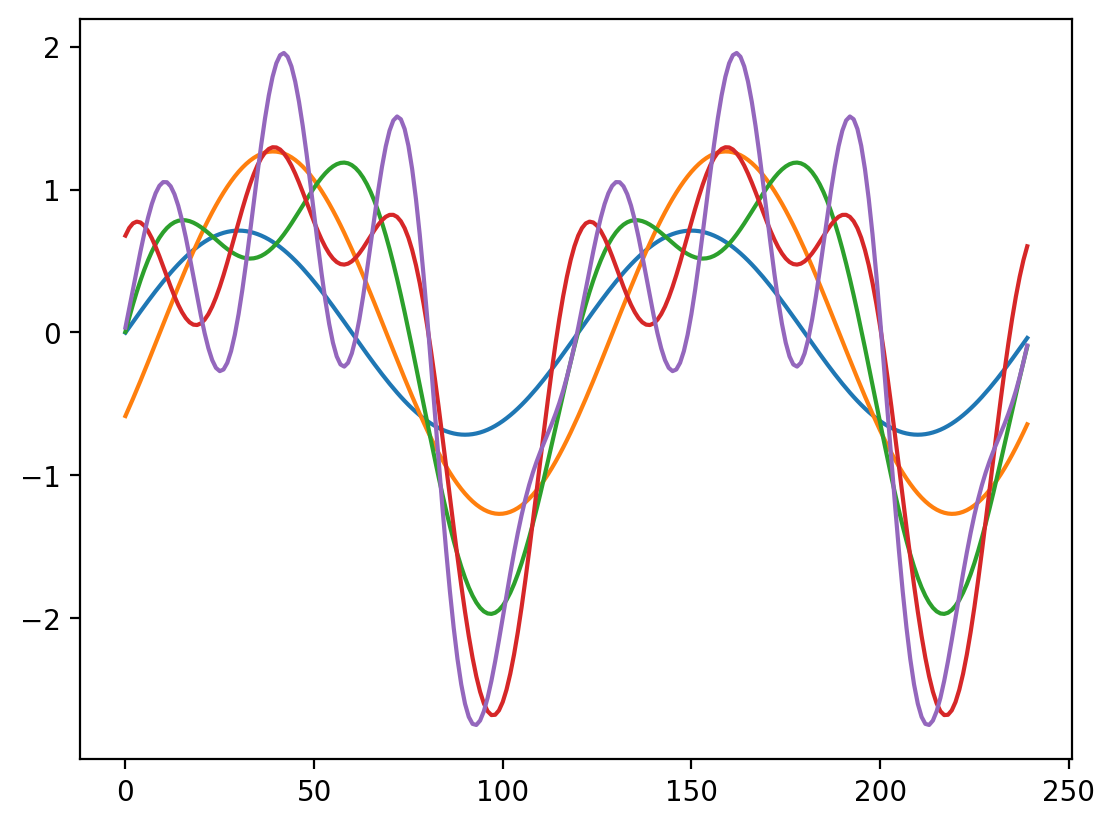

In [724]:
# multichannel data
n_channels = 5
y = np.zeros((num_samples, n_channels))

base_period = 120
base_freq = 1 / base_period

# y[:, 0] += sin_function(1, base_period, 0)
# y[:, 1] += sin_function(1, base_period + 20, np.pi / 2)

y[:, 0] += sin_function(1, base_period, 0)

for channel in range(1, n_channels):
    offset = 2 * np.random.rand() * np.pi
    # offset = 0
    # y[:, channel] += sin_function(1, base_period * (channel / 3 + 1), offset)
    y[:, channel] += sin_function(1, base_period / channel, offset)
    y[:, channel] += y[:, channel - 1]

# normalize
y = (y - np.mean(y)) / np.std(y)

plt.plot(y[:240])
plt.show()

In [725]:
from models.FITS import FITS

from argparse import Namespace

cuff_off_harmonic = 8
dominance_freq = int((240 / base_period) * cuff_off_harmonic)

args = Namespace(
    dominance_freq=20,
    seq_len=240,
    pred_len=120,
    channels=n_channels,
    individual=False,
    debug=False,
)

model = FITS(args)

model_optim = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [726]:
model, train_loss = train(model, model_optim, n_channels, y)

epoch: 999 	 loss: 0.000000

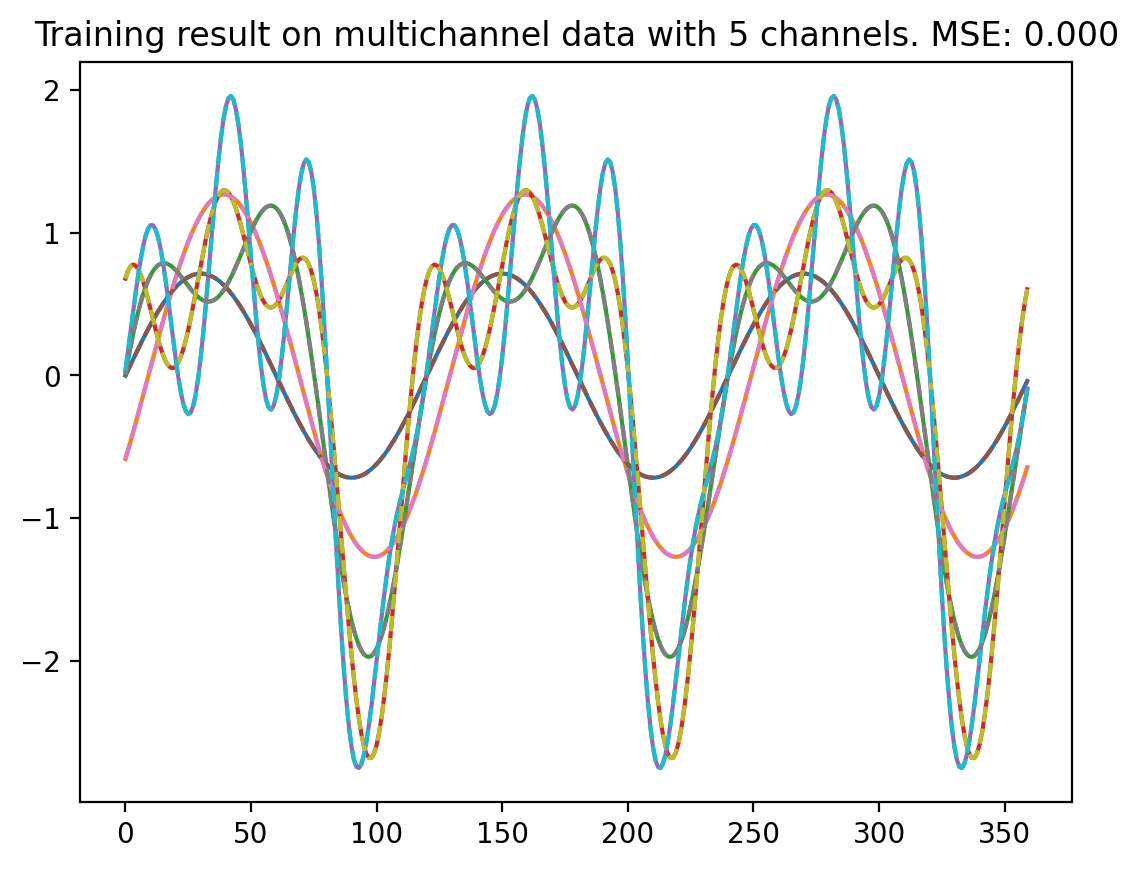

In [727]:
batch_xy = torch.from_numpy(y[:360].reshape(1, 360, n_channels)).float()
with torch.no_grad():
    output = model(batch_xy[:, :240, :])


plt.title(
    f"Training result on multichannel data with 5 channels. MSE: {np.mean(train_loss):.3f}"
)
plt.plot(output[0, :, :], label="Output")
plt.plot(batch_xy[0, :, :], "--", label="Ground truth")
plt.show()

## Individual config in model

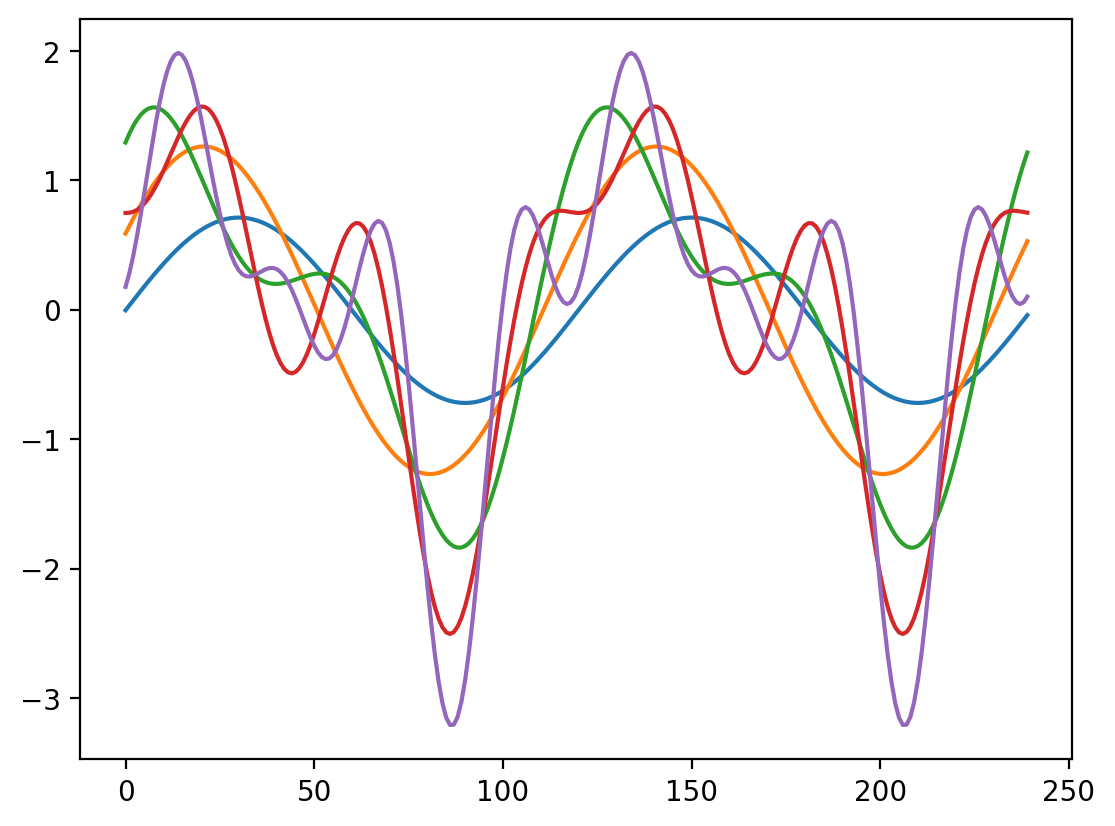

In [728]:
# multichannel data
n_channels = 5
y = np.zeros((num_samples, n_channels))

base_period = 120
base_freq = 1 / base_period

# y[:, 0] += sin_function(1, base_period, 0)
# y[:, 1] += sin_function(1, base_period + 20, np.pi / 2)

y[:, 0] += sin_function(1, base_period, 0)

for channel in range(1, n_channels):
    # offset = 0
    offset = 2 * np.random.rand() * np.pi
    # y[:, channel] += sin_function(1, base_period * (channel / 3 + 1), offset)
    y[:, channel] += sin_function(1, base_period / channel, offset)
    y[:, channel] += y[:, channel - 1]

# normalize
y = (y - np.mean(y)) / np.std(y)

plt.plot(y[:240])
plt.show()

In [729]:
from models.FITS import FITS

from argparse import Namespace

cuff_off_harmonic = 20
dominance_freq = int((240 / base_period) * cuff_off_harmonic)

args = Namespace(
    dominance_freq=20,
    seq_len=240,
    pred_len=120,
    channels=n_channels,
    individual=True,
    debug=False,
)

model = FITS(args)

model_optim = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

print(model)

FITS(
  (frequency_upsampler): ModuleList(
    (0-4): 5 x Linear(in_features=20, out_features=30, bias=True)
  )
)


In [730]:
model, train_loss = train(model, model_optim, n_channels, y)

epoch: 0 	 loss: 1.850352

epoch: 999 	 loss: 0.000000

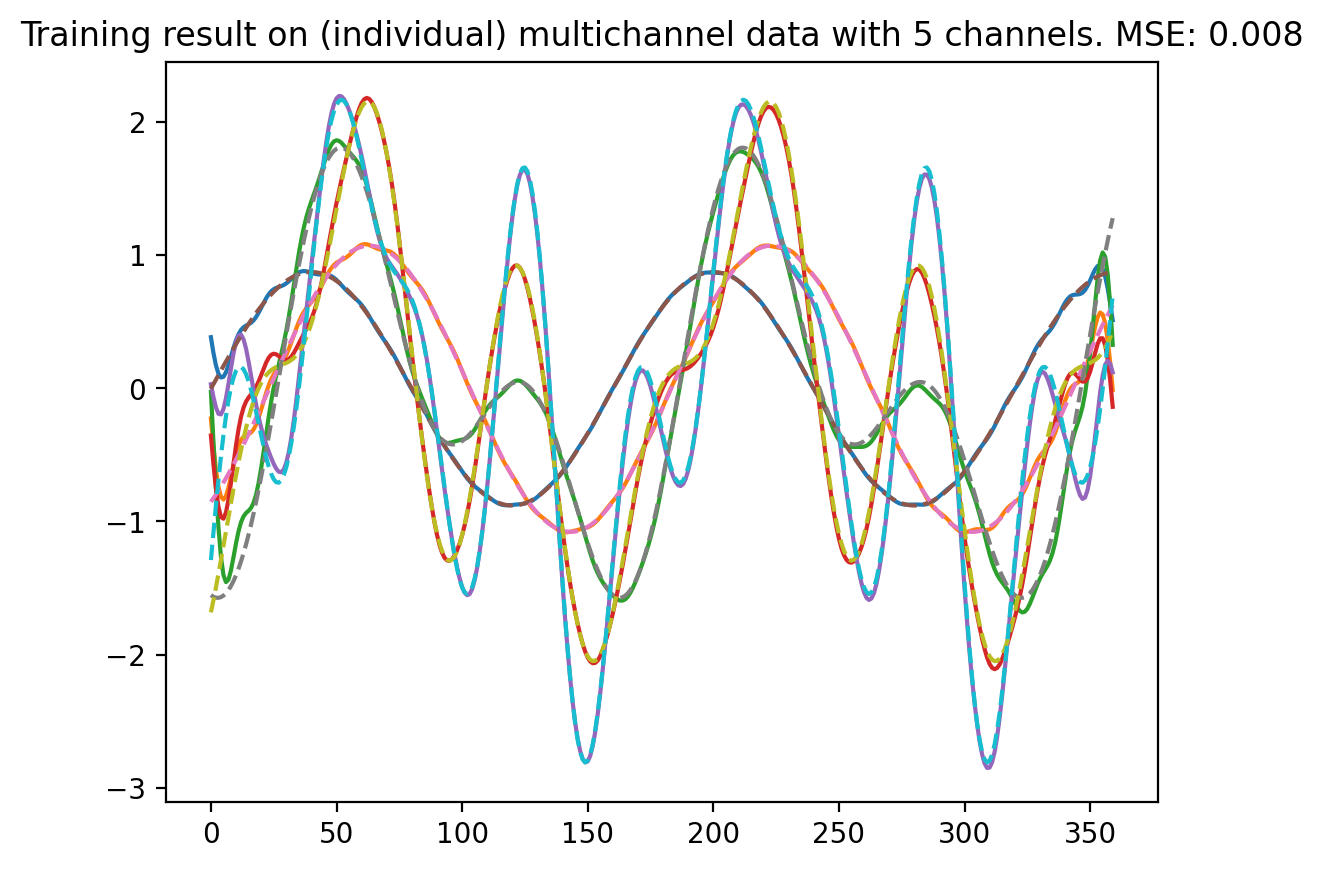

In [721]:
batch_xy = torch.from_numpy(y[:360].reshape(1, 360, n_channels)).float()
with torch.no_grad():
    output = model(batch_xy[:, :240, :])


plt.title(
    f"Training result on (individual) multichannel data with 5 channels. MSE: {train_loss:.3f}"
)
plt.plot(output[0, :, :], label="Output")
plt.plot(batch_xy[0, :, :], "--", label="Ground truth")
plt.show()

## Channels independent

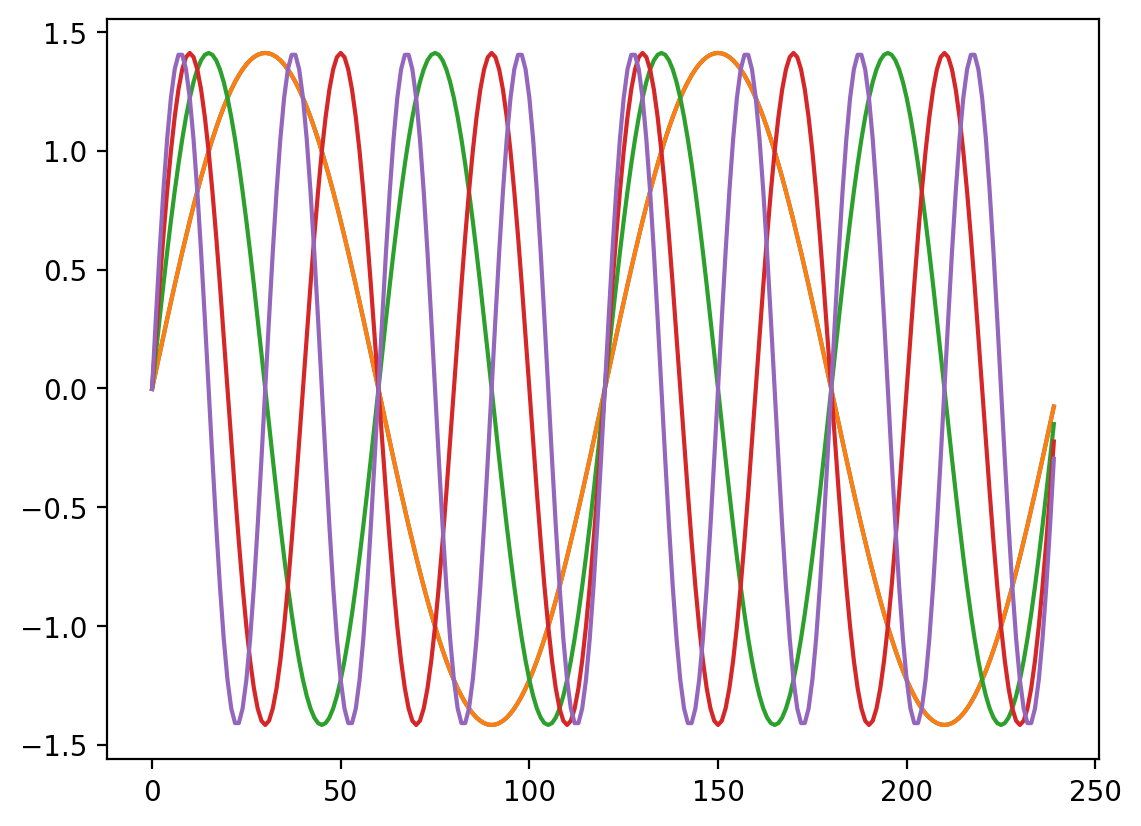

In [632]:
# multichannel data
n_channels = 5
y = np.zeros((num_samples, n_channels))

base_period = 120
base_freq = 1 / base_period

# y[:, 0] += sin_function(1, base_period, 0)
# y[:, 1] += sin_function(1, base_period + 20, np.pi / 2)

y[:, 0] += sin_function(1, base_period, 0)

for channel in range(1, n_channels):
    # offset = 2 * np.random.rand() * np.pi
    offset = 0
    # y[:, channel] += sin_function(1, base_period * (channel / 3 + 1), offset)
    y[:, channel] += sin_function(1, base_period / channel, offset)
    # y[:, channel] += y[:, channel - 1]

# normalize
y = (y - np.mean(y)) / np.std(y)


plt.plot(y[:240])
plt.show()

In [633]:
from models.FITS import FITS

from argparse import Namespace

cuff_off_harmonic = 10
dominance_freq = int((240 / base_period) * cuff_off_harmonic)

args = Namespace(
    dominance_freq=20,
    seq_len=240,
    pred_len=120,
    channels=n_channels,
    individual=False,
    debug=False,
)

model = FITS(args)

model_optim = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [634]:
model, train_loss = train(model, model_optim, n_channels, y)

epoch: 999 	 loss: 0.000000

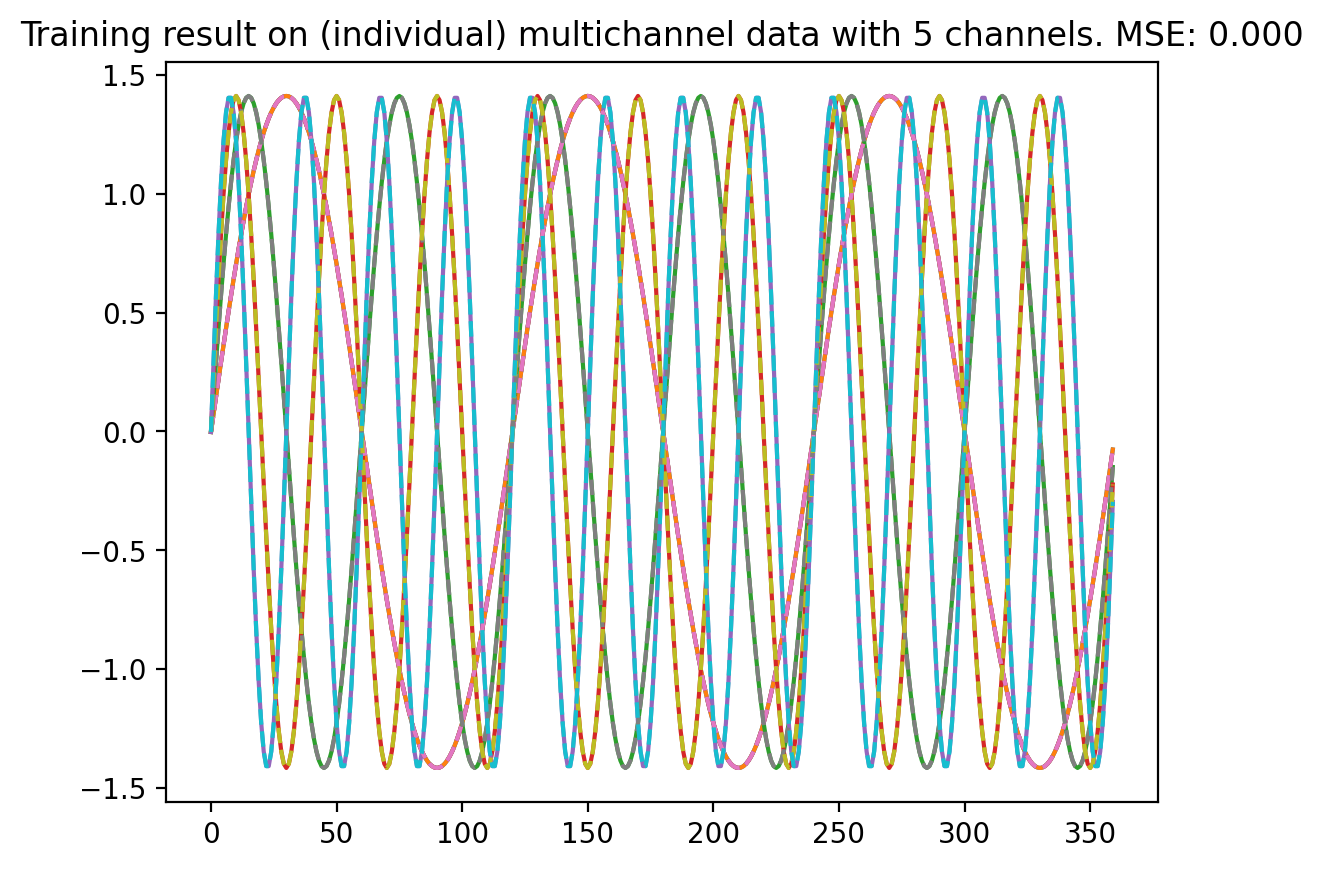

In [635]:
batch_xy = torch.from_numpy(y[:360].reshape(1, 360, n_channels)).float()
with torch.no_grad():
    output = model(batch_xy[:, :240, :])


plt.title(
    f"Training result on (individual) multichannel data with 5 channels. MSE: {np.mean(train_loss):.3f}"
)
plt.plot(output[0, :, :], label="Output")
plt.plot(batch_xy[0, :, :], "--", label="Ground truth")
plt.show()